In [36]:
using NPZ
using Interpolations
using Cubature
using PyCall
using LinearAlgebra
using BenchmarkTools
# mpb = pyimport("meep.mpb")
# mp = pyimport("meep")
# @pyimport matplotlib.animation as anim
using PyPlot
# using Plots
# pyplot()
include("xray_3dphc.jl")

BZ_boundaries (generic function with 1 method)

In [2]:
rcParams = PyDict(matplotlib["rcParams"])
rcParams["font.size"] = 10;
rcParams["font.sans-serif"] = "Arial";
rcParams["axes.labelsize"] = 12;
rcParams["xtick.labelsize"] = 12;
rcParams["ytick.labelsize"] = 12;
rcParams["legend.fontsize"] = 12;
rcParams["text.usetex"] = "False";
rcParams["svg.fonttype"] = "none";
rcParams["contour.negative_linestyle"] = "solid";
rcParams["contour.linewidth"] = 0.75;
rcParams["pcolor.shading"] = "auto";
rcParams["lines.linewidth"] = 0.75;
# rc("font", family="sans-serif")
# rc("font", size=12.0)
# rc("svg", fonttype="none")

In [3]:
cartesian_to_BCC_recip = 1/2 * [1 1 -1; -1 1 1; 1 -1 1]
BCC_to_cartesian_recip = [1 0 1; 1 1 0; 0 1 1]
BCC_recip_basis = [[1 1 0], [0 1 1], [1 0 1]]
BCC_basis = [[1/2 1/2 -1/2], [-1/2 1/2 1/2], [1/2 -1/2 1/2]]

FCC_to_cartesian_recip = [1 1 -1; -1 1 1; 1 -1 1]
cartesian_to_FCC_recip = 1/2 * [1 0 1; 1 1 0; 0 1 1]
FCC_recip_basis = [[1 -1 1], [1 1 -1], [-1 1 1]]
FCC_basis = [[1/2 0 1/2], [1/2 1/2 0], [0 1/2 1/2]]

3-element Array{Array{Float64,2},1}:
 [0.5 0.0 0.5]
 [0.5 0.5 0.0]
 [0.0 0.5 0.5]

## Read data from save files

In [4]:
# data = npzread("phc3d_more_g.npz")
# data= npzread("phc3d_constant_eps.npz")
data = npzread("phc_an_files/phc3d_fcc_25_12b.npz")

kBZ = data["arr_0"]
Δk = kBZ[2] - kBZ[1]
krange = -0.75:Δk:0.75
# krange = -0.5:Δk:0.5

M1dat = data["arr_1"]
M2dat = data["arr_2"]
M3dat = data["arr_3"]
ωdat = data["arr_4"]
vgdat = data["arr_5"];

Nb = size(ωdat)[1]
NM = size(M1dat)[5]
Nk = size(ωdat)[2]
ks = range(-0.75,0.75,length=70)
# ks = range(-0.5,0.5,length=70)


-0.75:0.021739130434782608:0.75

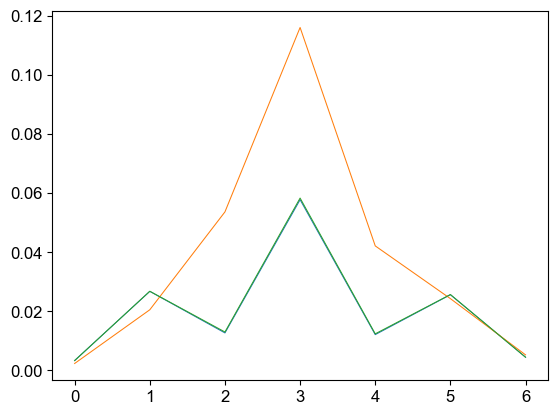

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f32337aa7d0>

In [8]:
plot(M1dat[1, 12, 12, 12, :, 4, 4])
plot(M2dat[1, 12, 12, 12, :, 4, 4])
plot(M3dat[1, 12, 12, 12, :, 4, 4])

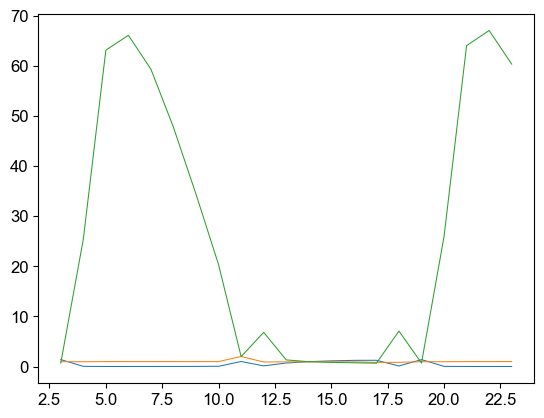

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f9209781450>

In [8]:
plot(M3dat[1, 12, :, 12, 4, 4, 4] ./ M1dat[1, 12, :, 12, 4, 4, 4])
plot(M2dat[1, 12, :, 12, 4, 4, 4] ./ M1dat[1, 12, :, 12, 4, 4, 4])
plot(M2dat[1, 12, :, 12, 4, 4, 4] ./ M3dat[1, 12, :, 12, 4, 4, 4])

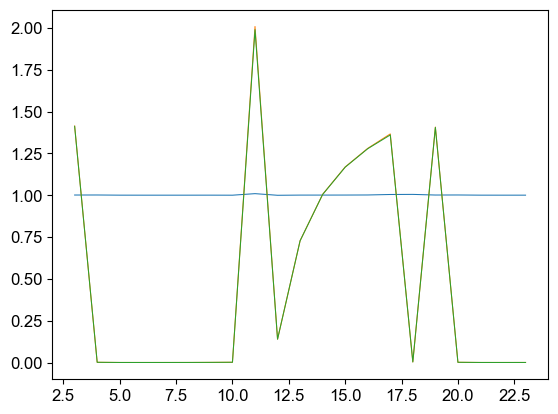

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f3f9b51c850>

In [39]:
plot(M3dat[1, :, 12, 12, 4, 4, 4] ./ M1dat[1, :, 12, 12, 4, 4, 4])
plot(M2dat[1, :, 12, 12, 4, 4, 4] ./ M1dat[1, :, 12, 12, 4, 4, 4])
plot(M2dat[1, :, 12, 12, 4, 4, 4] ./ M3dat[1, :, 12, 12, 4, 4, 4])

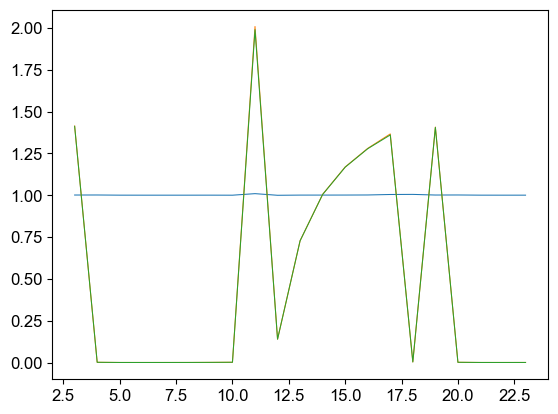

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f3f9b51c850>

In [39]:
plot(M3dat[1, :, 12, 12, 4, 4, 4] ./ M1dat[1, :, 12, 12, 4, 4, 4])
plot(M2dat[1, :, 12, 12, 4, 4, 4] ./ M1dat[1, :, 12, 12, 4, 4, 4])
plot(M2dat[1, :, 12, 12, 4, 4, 4] ./ M3dat[1, :, 12, 12, 4, 4, 4])

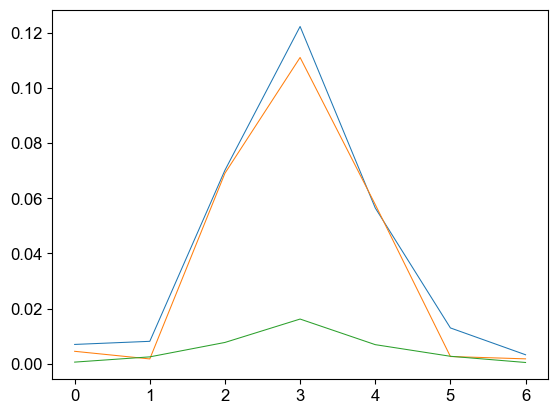

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f32336a26d0>

In [10]:
plot(M1dat[1, 12, 13, 12, :, 4, 4])
plot(M2dat[1, 12, 13, 12, :, 4, 4])
plot(M3dat[1, 12, 13, 12, :, 4, 4])

In [5]:
ωsplines = Array{Any,1}(undef, Nb)
k0 = Integer((Nk+1)/2) # Nk must be odd

for b in 1:Nb
    # replace zeros with an average so we don't go into a bandgap...
    ωband = ωdat[b,:,:,:]
#     avg = mean(ωband[ωband.!=0])
#     ωband[ωband.==0] .= avg
#     if ωdat[b,k0,k0,k0] == 0
#         ωband[k0,k0,k0] = 0
#     end
    
    ωitp = interpolate(ωband, BSpline(Quadratic(Flat(OnCell()))));
#     ωitp = interpolate(ωdat[b,:,:,:], BSpline(Linear()));
    ωsitp = scale(ωitp, krange, krange, krange);
    ωsplines[b] = ωsitp
end

In [6]:
Msplines = Array{Any,5}(undef, Nb, NM, NM, NM, 3)
# ks_1BZ_BCC = [in_1BZ_BCC(BCC_to_cartesian_recip * [kx, ky, kz]) ? 1 : 0 for kx in krange, ky in krange, kz in krange]
for i in 1:3
    key = string("arr_", i)
    Mdat = data[key]
    for b in 1:Nb
        for nx in 1:NM
            for ny in 1:NM
                for nz in 1:NM
#                     Mitp = interpolate(Mdat[b,:,:,:,nx,ny,nz], BSpline(Linear()));

                    Mitp = interpolate(Mdat[b,:,:,:,nx,ny,nz], BSpline(Quadratic(Flat(OnCell()))));
                    Msitp = scale(Mitp, krange, krange, krange);
                    Msplines[b,nx,ny,nz,i] = Msitp
                end
            end
        end
    end
end

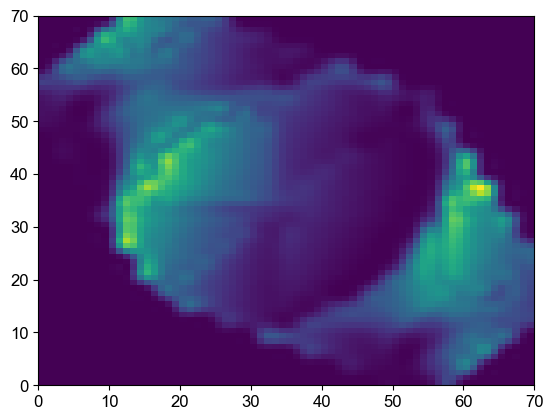

PyObject <matplotlib.collections.QuadMesh object at 0x7f9209763cd0>

In [12]:
nx = 4
ny = 3
nz = 4
Mspline1 = Msplines[1, nx, ny, nz, 1]
Mspline2 = Msplines[1, nx, ny, nz, 2]
Mspline3 = Msplines[1, nx, ny, nz, 3]

pcolormesh([Mspline1.(kx, ky, krange[12]).^2 .+ Mspline2.(kx, ky, krange[12]).^2 .+ Mspline3.(kx, ky, krange[12]).^2 for kx in ks, ky in ks])

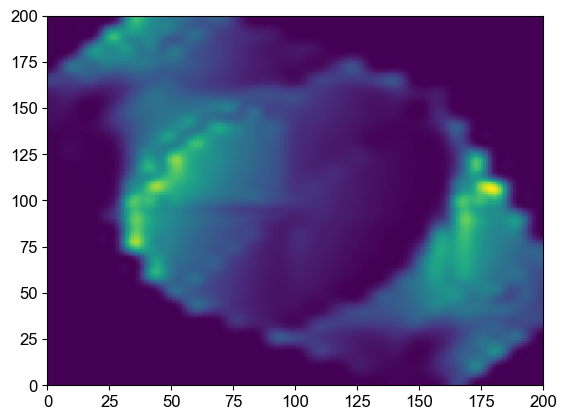

PyObject <matplotlib.collections.QuadMesh object at 0x7f9209842690>

In [13]:
more_ks = range(-0.75, 0.75, length=200)
pcolormesh([Mspline1.(kx, ky, krange[12]).^2 .+ Mspline2.(kx, ky, krange[12]).^2 .+ Mspline3.(kx, ky, krange[12]).^2 for kx in more_ks, ky in more_ks])

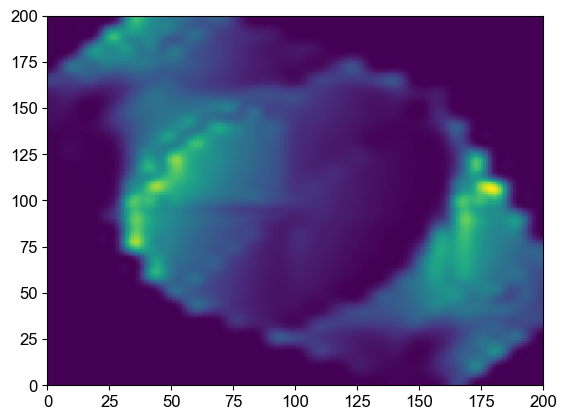

PyObject <matplotlib.collections.QuadMesh object at 0x7f925ab2bf50>

In [14]:
more_ks = range(-0.75, 0.75, length=200)
pcolormesh([Mspline1.(kx, ky, krange[12]).^2 .+ Mspline2.(kx, ky, krange[12]).^2 .+ Mspline3.(kx, ky, krange[12]).^2 for kx in more_ks, ky in more_ks])

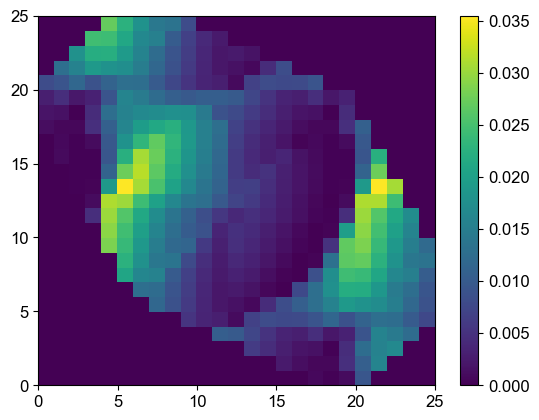

PyObject <matplotlib.colorbar.Colorbar object at 0x7f920a67fd10>

In [15]:
pcolormesh(M1dat[1, :, :, 12, nx, ny, nz].^2 .+ M2dat[1, :, :, 12,nx, ny, nz].^2 .+ M3dat[1, :, :, 12, nx, ny, nz].^2)
colorbar()

In [17]:
ωp = 1e19
ωi = 2e15
ωs = ωp - ωi
#dmnd and ln
g = 3.1e10 #being approximate here
# ga
# g = 1.95e10
gvec = g * [1,0,0]
θB = asin(g*c/(2*ωp))
# println(θB)

# χ = 2e-17 #dmmd
χ = 1.3e-13 # LN
# χ = 4.7e-14 # GA
np = 1e14
# a = 0.5e-6 #PhC lattice spacing
a = 0.5e-6 # free space lattice spacing.... get more accurate modes??
L = 1e-4 #1mm where period is micron scale sounds reasonable

θdev = 0.0005
ϕdev = 0.0005

P = PumpBeam(1e19, θB, 0.0)
D_fcc = PhC_Data(a, Msplines, ωsplines, 0);

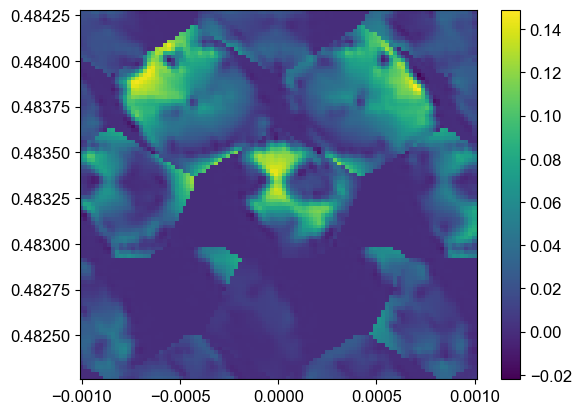

PyObject <matplotlib.colorbar.Colorbar object at 0x7f3f9b455f90>

In [41]:
ωi = 1/ħeV #2/ħeV
Nangles = 100
θdev = 0.001
ϕdev = 0.001
dat = zeros(Nangles,Nangles)
θrange = range(θB - θdev, θB + θdev, length=Nangles)
ϕrange = range(-ϕdev, ϕdev, length=Nangles)
Δθ = θrange[2]-θrange[1]
Δϕ = ϕrange[2]-ϕrange[1]

# noffset, k0_vec_no_unit, k_r, M0, ωi, lor, M02
# Threads.@threads for b in 1:Nb
#     newdat = [info_stitch_FCC(ωp - ωi, θs, ϕs, gvec, P, D_fcc, χ, np, L, b, 1, 0.2e13)[4]#*sin(θs)
#                         for θs in θrange, ϕs in ϕrange]
#     global dat .+= newdat
# end
dat = [info_stitch_FCC(ωp - ωi, θs, ϕs, gvec, P, D_fcc, χ, np, L, 1, 1, 0.2e13)[4]#*ħeV
                        for θs in θrange, ϕs in ϕrange]

dat_fcc_med = dat

pcolormesh(ϕrange, θrange, dat)
colorbar()
# PyPlot.contour(ϕrange, θrange, colors1m, levels=-5.5:5.5, colors=["white"])
# PyPlot.contour(ϕrange, θrange, colors2m, levels=-5.5:5.5, colors=["white"])
# PyPlot.contour(ϕrange, θrange, colors3m, levels=-5.5:5.5, colors=["white"])

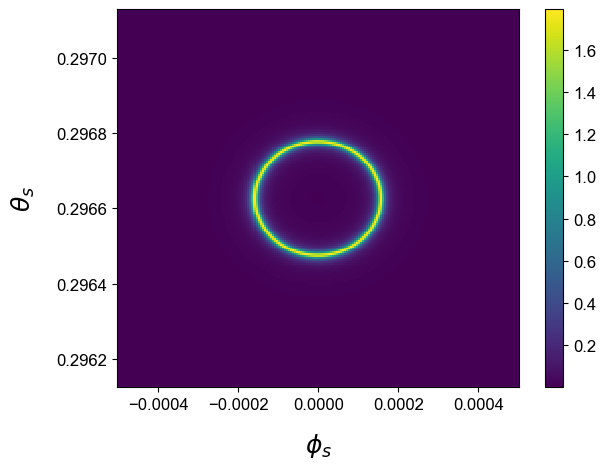

In [50]:
ωi = 0.3/ħeV #2/ħeV
Nangles = 200
# dat2 = zeros(Nangles,Nangles)
θrange = range(θB - θdev, θB + θdev, length=Nangles)
ϕrange = range(-ϕdev, ϕdev, length=Nangles)
Δθ = θrange[2]-θrange[1]
Δϕ = ϕrange[2]-ϕrange[1]

#    1              2       3  4    5    6     7       8      9
# noffset, k0_vec_no_unit, M0, ωi, lor, Ep2, prefac, kbvec, Msplines
dat2 = [(dΓdωdΩ_free(ωp - ωi, θs, ϕs, gvec, P, 12, χ, np, L, pol="te")*cos(θs)
        + dΓdωdΩ_free(ωp - ωi, θs, ϕs, gvec, P, 12, χ, np, L, pol="tm")*cos(θs))
                    for θs in θrange, ϕs in ϕrange]
# dat = [info_stitch_BCC(ωp - ωi, θs, ϕs, gvec, P, D_bcc, χ, np, L, 6)[6]
#                         for θs in θrange, ϕs in ϕrange]


pcolormesh(ϕrange, θrange, dat2)
xlabel(L"$ϕ_s$", fontsize=18.0, labelpad=14.0)
ylabel(L"$θ_s$", fontsize=18.0, labelpad=14)
colorbar()
tight_layout()

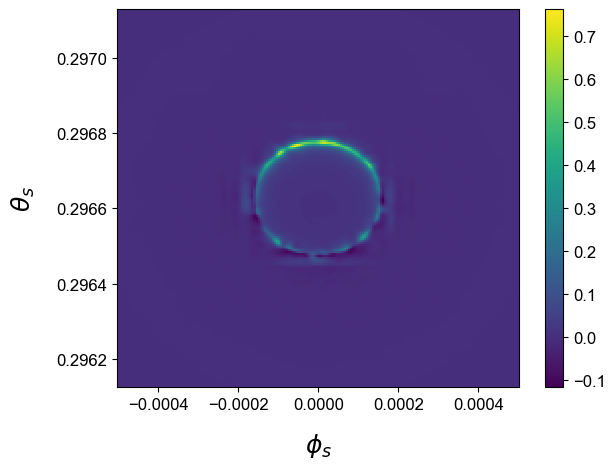

In [51]:
pcolormesh(ϕrange, θrange, dat2.-dat)
xlabel(L"$ϕ_s$", fontsize=18.0, labelpad=14.0)
ylabel(L"$θ_s$", fontsize=18.0, labelpad=14)
colorbar()
tight_layout()

In [52]:
sum(dat)-sum(dat2)

-186.33626391530242

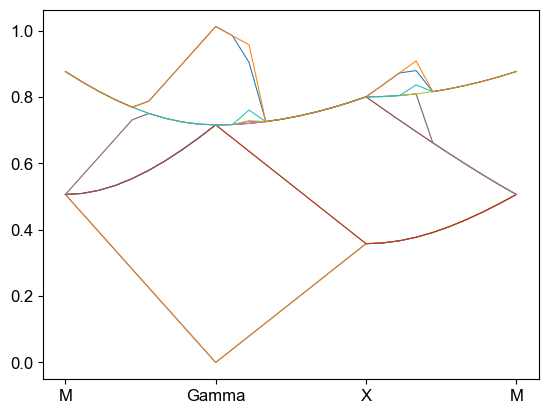

(PyObject[PyObject <matplotlib.axis.XTick object at 0x7f6503592c10>, PyObject <matplotlib.axis.XTick object at 0x7f650356b7d0>, PyObject <matplotlib.axis.XTick object at 0x7f650356b3d0>, PyObject <matplotlib.axis.XTick object at 0x7f650381cfd0>], PyObject[PyObject Text(0, 0, 'M'), PyObject Text(9, 0, 'Gamma'), PyObject Text(18, 0, 'X'), PyObject Text(27, 0, 'M')])

In [33]:
bands_sc = npzread("phc_an_files/phc3d_sc_fs_bands_e_12_12.npz")["arr_0"]
plt.plot(bands_sc* 2π* c /0.5e-6 * ħeV)
plt.xticks([0, 9, 18, 27], ["M", "Gamma", "X", "M"])

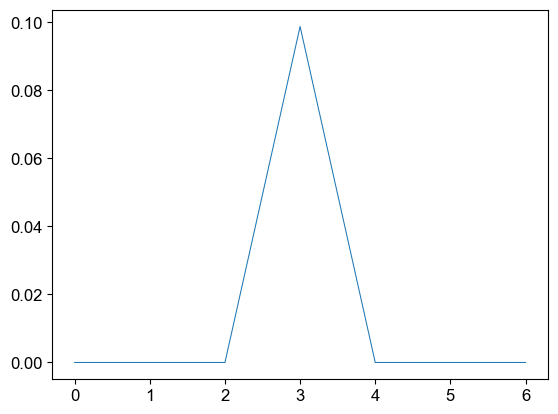

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7ff40c750390>

In [120]:
plot([M3dat[1, 7,7,7, nx, 4, 4] for nx in 1:7])

In [ ]:
pcolormesh(ϕrange, θrange, dat)


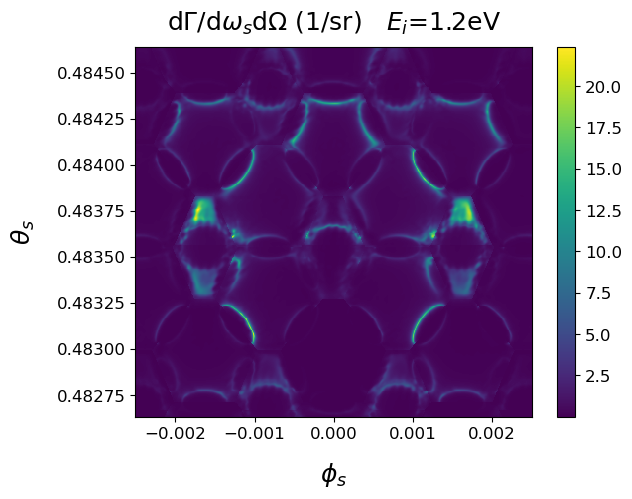

PyObject <matplotlib.colorbar.Colorbar object at 0x7f41f8080c10>

In [42]:
ωi = 1.7/ħeV #2/ħeV
Nangles = 400
dat = zeros(Nangles,Nangles)
θrange = range(θB - θdev, θB + θdev, length=Nangles)
ϕrange = range(-ϕdev, ϕdev, length=Nangles)
Δθ = θrange[2]-θrange[1]
Δϕ = ϕrange[2]-ϕrange[1]

# noffset, k0_vec_no_unit, k_r, M0, ωi, lor
Threads.@threads for b in 1:Nb
    newdat = [dΓdωdΩ_stitch_BCC(ωp - ωi, θs, ϕs, gvec, P, D_bcc_25, χ, np, L, b)*sin(θs)
                        for θs in θrange, ϕs in ϕrange]
    global dat .+= newdat
end
# dat = [info_stitch_BCC(ωp - ωi, θs, ϕs, gvec, P, D_bcc, χ, np, L, 6)[6]
#                         for θs in θrange, ϕs in ϕrange]

dat_fcc_low = dat
pcolormesh(ϕrange, θrange, dat)
title(L"dΓ/d$ω_s$dΩ (1/sr) $~~E_i$=1.2eV", fontsize=18.0, pad=12)
xlabel(L"$ϕ_s$", fontsize=18.0, labelpad=14.0)
ylabel(L"$θ_s$", fontsize=18.0, labelpad=14)
colorbar()

In [47]:
ωi = 1/ħeV #2/ħeV
Nangles = 100
θdev = 0.005
ϕdev = 0.005
dat = zeros(Nangles,Nangles)
θrange = range(θB - θdev, θB + θdev, length=Nangles)
ϕrange = range(-ϕdev, ϕdev, length=Nangles)
Δθ = θrange[2]-θrange[1]
Δϕ = ϕrange[2]-ϕrange[1]

# noffset, k0_vec_no_unit, k_r, M0, ωi, lor
Threads.@threads for b in 1:Nb
    newdat = [info_stitch_FCC(ωp - ωi, θs, ϕs, gvec, P, D_fcc, χ, np, L, b, 1, 0.2e13)[1][1]#*sin(θs)
                        for θs in θrange, ϕs in ϕrange]
    global dat .+= newdat
end
# dat = [info_stitch_FCC(ωp - ωi, θs, ϕs, gvec, P, D_dmnd_25, χ, np, L, 2, 1, 0.2e13)[6]#*ħeV
#                         for θs in θrange, ϕs in ϕrange]

dat_fcc_med = dat

pcolormesh(ϕrange, θrange, dat)
colorbar()
# PyPlot.contour(ϕrange, θrange, colors1m, levels=-5.5:5.5, colors=["white"])
# PyPlot.contour(ϕrange, θrange, colors2m, levels=-5.5:5.5, colors=["white"])
# PyPlot.contour(ϕrange, θrange, colors3m, levels=-5.5:5.5, colors=["white"])

offset is too much
offset is too much
offset is too much
offset is too much
offset is too much
offset is too much
offset is too much
offset is too much
[-5, 763, -781]
[-5, 763, -781]
[-5, 763, -781]
[-5, 763, -781]
[-5, 763, -781]
offset is too much
[-5, 763, -781]
offset is too much
offset is too much
[-5, 763, -781]
offset is too much
offset is too much
[-5, 763, -781]
[-5, 763, -781]
offset is too much
[-5, 763, -781]
offset is too much
[-5, 763, -781]
offset is too much
[-5, 763, -781]
offset is too much
[-5, 763, -781]
[-5, 763, -781]
[-5, 763, -781]
offset is too much
[-5, 763, -781]
offset is too much
[-5, 763, -781]
[-5, 763, -781]
[-5, 763, -781]
offset is too much
offset is too much
[-4, 764, -780]
offset is too much
offset is too much
offset is too much
[-5, 763, -781]
offset is too much
[-4, 764, -781]
offset is too much
offset is too much
[-5, 763, -781]
offset is too much
[-5, 763, -781]
[-5, 763, -781]
[-5, 763, -781]
[-4, 764, -781]
offset is too much
offset is too muc

offset is too much
offset is too much
offset is too much
offset is too much
[-1, 768, -782]
offset is too much
offset is too much
offset is too much
[-1, 769, -782]
[-1, 769, -782]
[-1, 769, -782]
[-2, 767, -782]
offset is too much
[-1, 768, -782]
[-1, 768, -782]
offset is too much
[-1, 769, -782]
offset is too much
offset is too much
offset is too much
[-1, 768, -782]
[-2, 767, -782]
offset is too much
offset is too much
[-1, 769, -782]
[-1, 768, -782]
[-1, 769, -782]
offset is too much
offset is too much
offset is too much
offset is too much
[-1, 768, -782]
[-2, 767, -782]
[0, 769, -782]
[-1, 768, -782]
offset is too much
offset is too much
offset is too much
offset is too much
[0, 769, -782]
[0, 769, -782]
[-1, 768, -782]
[-1, 768, -782]
offset is too much
offset is too much
offset is too much
offset is too much
offset is too much
[-1, 768, -782]
[0, 769, -782]
offset is too much
[-1, 768, -782]
[-1, 768, -782]
offset is too much
[-1, 768, -782]
[0, 770, -782]
offset is too much
off

offset is too much
[3, 775, -784]
offset is too much
offset is too much
[3, 774, -784]
offset is too much
[2, 772, -783]
[3, 774, -784]
offset is too much
offset is too much
[2, 773, -783]
offset is too much
offset is too much
[-5, 763, -781]
offset is too much
[3, 774, -784]
[4, 775, -784]
offset is too much
[2, 773, -783]
offset is too much
[2, 773, -783]
offset is too much
[-4, 765, -781]
offset is too much
[-5, 763, -781]
[3, 775, -784]
offset is too much
offset is too much
[2, 773, -783]
offset is too much
[2, 773, -783]
[4, 775, -784]
offset is too much
offset is too much
offset is too much
offset is too much
[2, 773, -783]
[2, 773, -783]
offset is too much
offset is too much
[3, 774, -784]
offset is too much
[4, 775, -784]
[3, 775, -784]
offset is too much
[2, 773, -783]
offset is too much
[-4, 764, -780]
[3, 774, -784]
[2, 773, -783]
offset is too much
offset is too much
[3, 774, -784]
offset is too much
[2, 773, -783]
[4, 775, -784]
offset is too much
[-3, 765, -781]
[2, 773, 

[-2, 767, -782]
offset is too much
[-1, 769, -782]
offset is too much
[-3, 765, -781]
offset is too much
[-2, 767, -782]
[-4, 764, -781]
[0, 770, -782]
offset is too much
offset is too much
offset is too much
offset is too much
[-2, 767, -782]
offset is too much
[-4, 764, -781]
[-1, 769, -782]
[0, 770, -782]
offset is too much
offset is too much
offset is too much
[-1, 769, -782]
offset is too much
[-2, 767, -782]
[0, 770, -782]
offset is too much
offset is too much
[-3, 765, -781]
[-3, 766, -781]
offset is too much
[-4, 765, -781]
offset is too much
[0, 770, -782]
offset is too much
offset is too much
[-3, 766, -781]
[-4, 765, -781]
offset is too much
offset is too much
offset is too much
[0, 770, -782]
[-3, 766, -781]
[-3, 766, -781]
offset is too much
offset is too much
offset is too much
[0, 770, -782]
[0, 770, -782]
offset is too much
[-3, 766, -781]
[-2, 768, -782]
offset is too much
offset is too much
[-3, 765, -781]
offset is too much
[0, 770, -782]
offset is too much
[-3, 765,

[4, 775, -784]
[3, 774, -784]
[4, 776, -784]
offset is too much
[0, 770, -782]
[0, 770, -782]
offset is too much
offset is too much
[3, 774, -784]
[-5, 763, -780]
[0, 770, -782]
offset is too much
offset is too much
offset is too much
offset is too much
offset is too much
offset is too much
[0, 770, -782]
[0, 770, -782]
[-4, 764, -780]
[1, 771, -782]
offset is too much
[0, 770, -783]
offset is too much
offset is too much
offset is too much
[0, 770, -783]
[4, 775, -784]
[0, 770, -782]
offset is too much
[-4, 764, -780]
[1, 771, -783]
[0, 770, -783]
offset is too much
offset is too much
[0, 770, -783]
[-4, 764, -780]
offset is too much
offset is too much
[3, 774, -784]
[4, 776, -784]
offset is too much
offset is too much
offset is too much
offset is too much
[3, 774, -784]
[4, 776, -784]
offset is too much
[-4, 764, -780]
offset is too much
offset is too much
offset is too much
[0, 770, -782]
[0, 770, -783]
offset is too much
[0, 770, -783]
offset is too much
[3, 774, -784]
offset is too

[3, 775, -784]
offset is too much
[1, 771, -782]
offset is too much
[2, 773, -784]
offset is too much
[-1, 769, -782]
[-1, 769, -782]
[3, 774, -784]
offset is too much
offset is too much
[2, 773, -784]
[-1, 769, -782]
offset is too much
offset is too much
[3, 774, -783]
offset is too much
offset is too much
[-1, 769, -782]
offset is too much
[0, 770, -782]
[1, 771, -783]
offset is too much
offset is too much
[3, 775, -784]
offset is too much
[0, 770, -782]
offset is too much
offset is too much
[3, 774, -783]
[-1, 769, -782]
[1, 771, -783]
offset is too much
[3, 774, -783]
offset is too much
offset is too much
offset is too much
[3, 774, -783]
[1, 771, -783]
[-1, 769, -782]
offset is too much
[3, 775, -784]
offset is too much
offset is too much
offset is too much
[3, 775, -784]
offset is too much
[-1, 769, -782]
[3, 774, -783]
offset is too much
offset is too much
[1, 771, -783]
[-1, 769, -782]
[3, 774, -783]
offset is too much
offset is too much
offset is too much
[3, 775, -784]
offset

offset is too much
offset is too much
[-2, 767, -781]
offset is too much
[3, 775, -784]
[3, 775, -784]
offset is too much
offset is too much
[-3, 766, -781]
[-3, 766, -781]
offset is too much
offset is too much
offset is too much
[-3, 765, -781]
offset is too much
[-3, 766, -781]
offset is too much
offset is too much
[3, 775, -784]
[-3, 766, -781]
[-2, 767, -781]
[-4, 765, -781]
offset is too much
offset is too much
offset is too much
[4, 776, -784]
[3, 775, -784]
[-2, 767, -781]
offset is too much
offset is too much
[4, 776, -784]
offset is too much
[-3, 766, -781]
[-3, 766, -781]
offset is too much
offset is too much
[-4, 765, -781]
[4, 776, -784]
offset is too much
offset is too much
[-2, 767, -781]
offset is too much
offset is too much
offset is too much
[4, 776, -784]
offset is too much
offset is too much
offset is too much
[-3, 766, -781]
[4, 776, -784]
[-3, 766, -781]
[-4, 765, -781]
[4, 776, -784]
offset is too much
offset is too much
[4, 776, -784]
[-3, 766, -781]
[-2, 767, -7

[0, 770, -782]
offset is too much
[-2, 768, -782]
[1, 772, -783]
offset is too much
offset is too much
offset is too much
[1, 771, -783]
[0, 770, -782]
[-2, 768, -782]
offset is too much
[0, 770, -782]
offset is too much
offset is too much
[0, 770, -782]
[-1, 769, -781]
[1, 771, -783]
[2, 773, -783]
offset is too much
offset is too much
[2, 773, -783]
offset is too much
offset is too much
[2, 773, -783]
[1, 771, -783]
[-1, 769, -782]
offset is too much
[0, 770, -782]
offset is too much
offset is too much
offset is too much
[0, 770, -782]
[-1, 769, -782]
offset is too much
offset is too much
[2, 773, -783]
[0, 770, -782]
[2, 773, -783]
[0, 770, -782]
offset is too much
offset is too much
offset is too much
[1, 772, -783]
offset is too much
offset is too much
offset is too much
offset is too much
[0, 770, -783]
[1, 772, -783]
[0, 770, -782]
[-1, 769, -782]
offset is too much
offset is too much
[1, 772, -783]
[0, 770, -782]
offset is too much
offset is too much
offset is too much
[-1, 769

[3, 775, -784]
[3, 775, -784]
offset is too much
offset is too much
offset is too much
[3, 775, -784]
[3, 774, -783]
[3, 775, -784]
[-3, 766, -780]
offset is too much
offset is too much
offset is too much
offset is too much
offset is too much
[3, 774, -783]
offset is too much
[-5, 764, -780]
[4, 776, -784]
offset is too much
[-3, 766, -781]
[3, 775, -784]
offset is too much
[3, 774, -783]
offset is too much
offset is too much
[-4, 764, -780]
[3, 775, -784]
offset is too much
offset is too much
[4, 776, -784]
[-4, 764, -780]
offset is too much
offset is too much
[3, 775, -783]
[-3, 766, -781]
offset is too much
offset is too much
offset is too much
[-3, 766, -781]
offset is too much
[4, 776, -784]
[3, 775, -784]
offset is too much
[3, 775, -783]
offset is too much
[3, 774, -783]
[-4, 764, -780]
[4, 776, -784]
[-3, 766, -781]
offset is too much
offset is too much
[3, 774, -783]
offset is too much
offset is too much
[-4, 764, -780]
[4, 776, -784]
offset is too much
offset is too much
offs

[0, 771, -782]
offset is too much
[-3, 766, -781]
offset is too much
[-2, 768, -781]
[-2, 768, -782]
[0, 770, -782]
offset is too much
[-2, 768, -781]
[-3, 766, -781]
offset is too much
offset is too much
[0, 770, -782]
offset is too much
[0, 771, -782]
offset is too much
offset is too much
offset is too much
[-2, 767, -781]
[-1, 769, -781]
[0, 771, -782]
offset is too much
[0, 770, -782]
offset is too much
[-2, 768, -781]
offset is too much
[0, 769, -782]
offset is too much
[1, 771, -782]
offset is too much
offset is too much
[-2, 768, -781]
[-2, 767, -781]
[1, 771, -782]
offset is too much
[-1, 769, -781]
[0, 771, -782]
[1, 771, -782]
offset is too much
offset is too much
[-1, 768, -781]
[1, 771, -782]
offset is too much
offset is too much
offset is too much
offset is too much
[0, 771, -782]
[-1, 769, -781]
offset is too much
offset is too much
offset is too much
[-2, 768, -782]
[1, 771, -782]
[0, 771, -782]
offset is too much
[1, 772, -782]
offset is too much
offset is too much
offs

[-4, 765, -780]
offset is too much
[-4, 764, -780]
offset is too much
[1, 772, -783]
offset is too much
[3, 775, -783]
offset is too much
offset is too much
offset is too much
[2, 773, -783]
[1, 772, -783]
offset is too much
[-4, 765, -780]
[3, 775, -783]
[-4, 764, -780]
offset is too much
[1, 772, -783]
offset is too much
offset is too much
offset is too much
offset is too much
offset is too much
[2, 773, -783]
offset is too much
[-4, 765, -780]
[1, 772, -783]
offset is too much
[-4, 765, -780]
[3, 775, -783]
offset is too much
[2, 773, -783]
offset is too much
[-4, 765, -780]
offset is too much
offset is too much
[1, 772, -783]
[2, 773, -783]
offset is too much
[3, 775, -783]
[-4, 765, -780]
offset is too much
offset is too much
offset is too much
[-4, 765, -780]
[2, 773, -783]
[2, 773, -783]
offset is too much
[1, 772, -783]
offset is too much
[2, 773, -783]
offset is too much
[-4, 765, -781]
offset is too much
offset is too much
offset is too much
[3, 775, -783]
[-4, 765, -780]
[4,

[-1, 769, -782]
offset is too much
[1, 772, -782]
[-1, 769, -781]
[-3, 766, -781]
offset is too much
offset is too much
[1, 772, -782]
offset is too much
offset is too much
[-3, 766, -781]
offset is too much
[-2, 767, -781]
[-3, 766, -780]
[0, 770, -782]
offset is too much
[-1, 769, -781]
[-3, 766, -781]
offset is too much
offset is too much
[1, 772, -782]
offset is too much
[1, 772, -782]
offset is too much
offset is too much
offset is too much
[-3, 766, -781]
offset is too much
offset is too much
[-1, 769, -781]
[-3, 766, -781]
[-2, 767, -781]
[1, 772, -782]
offset is too much
offset is too much
[1, 771, -783]
offset is too much
offset is too much
offset is too much
[0, 770, -782]
offset is too much
[-1, 769, -781]
[1, 772, -782]
[1, 772, -782]
[-2, 767, -781]
[-3, 766, -781]
[-3, 766, -781]
offset is too much
offset is too much
offset is too much
[1, 772, -782]
[1, 772, -782]
offset is too much
[-2, 767, -781]
offset is too much
offset is too much
[-1, 769, -781]
[1, 772, -782]
[0, 

offset is too much
[1, 771, -782]
[0, 771, -782]
[3, 775, -783]
offset is too much
offset is too much
offset is too much
[4, 776, -784]
[-4, 765, -780]
[3, 774, -783]
[0, 771, -782]
[1, 771, -783]
offset is too much
offset is too much
[-4, 765, -780]
[4, 776, -784]
offset is too much
offset is too much
[3, 774, -783]
offset is too much
[0, 771, -782]
offset is too much
offset is too much
offset is too much
[3, 774, -783]
[0, 771, -782]
[3, 775, -783]
offset is too much
[-5, 764, -780]
[-4, 765, -780]
offset is too much
offset is too much
offset is too much
offset is too much
offset is too much
[3, 775, -783]
offset is too much
[-4, 765, -780]
[3, 775, -783]
[1, 772, -782]
[1, 771, -782]
[-5, 764, -780]
offset is too much
offset is too much
offset is too much
offset is too much
[1, 772, -783]
offset is too much
[3, 775, -783]
[3, 775, -783]
[-4, 765, -780]
offset is too much
offset is too much
offset is too much
offset is too much
[1, 772, -782]
[3, 775, -783]
offset is too much
[-5, 76

[0, 770, -781]
[-2, 767, -781]
offset is too much
[-5, 764, -780]
[-2, 767, -781]
offset is too much
offset is too much
offset is too much
offset is too much
offset is too much
[-2, 767, -781]
[0, 771, -782]
[3, 775, -784]
[-5, 764, -780]
offset is too much
offset is too much
offset is too much
[-2, 768, -781]
offset is too much
offset is too much
[0, 770, -781]
[0, 771, -782]
[-4, 764, -780]
offset is too much
[4, 776, -783]
[3, 775, -784]
[-2, 768, -781]
offset is too much
[-2, 768, -781]
offset is too much
offset is too much
[3, 775, -784]
[4, 776, -784]
offset is too much
offset is too much
offset is too much
[-4, 764, -780]
[-2, 768, -781]
[0, 771, -782]
offset is too much
offset is too much
[-2, 768, -781]
[0, 770, -781]
offset is too much
[3, 775, -784]
offset is too much
offset is too much
offset is too much
[-4, 765, -780]
[4, 776, -784]
offset is too much
offset is too much
[-4, 765, -780]
[-2, 768, -781]
[2, 772, -783]
[0, 771, -782]
offset is too much
offset is too much
off

[-2, 768, -781]
[-2, 768, -781]
[0, 770, -782]
offset is too much
[4, 776, -783]
offset is too much
[2, 773, -783]
offset is too much
offset is too much
[4, 776, -783]
offset is too much
offset is too much
offset is too much
[2, 773, -783]
[-2, 768, -781]
offset is too much
[0, 770, -782]
[4, 776, -783]
offset is too much
[-2, 768, -781]
[4, 776, -784]
[2, 773, -783]
offset is too much
offset is too much
[0, 771, -782]
[-2, 768, -781]
offset is too much
offset is too much
[-2, 768, -781]
offset is too much
[2, 773, -783]
[-1, 769, -781]
offset is too much
offset is too much
offset is too much
[2, 774, -783]
[-2, 768, -781]
[4, 776, -783]
offset is too much
offset is too much
offset is too much
[2, 774, -783]
[-1, 769, -781]
[4, 776, -784]
offset is too much
[2, 774, -783]
offset is too much
offset is too much
offset is too much
offset is too much
[2, 774, -783]
[0, 771, -782]
[4, 776, -783]
[-1, 769, -781]
offset is too much
offset is too much
offset is too much
[2, 774, -783]
[4, 776,

offset is too much
offset is too much
offset is too much
offset is too much
[4, 776, -784]
[2, 773, -782]
[-3, 767, -781]
offset is too much
offset is too much
[2, 773, -782]
[3, 775, -783]
offset is too much
offset is too much
[-3, 766, -780]
[-1, 769, -781]
[4, 776, -784]
offset is too much
[-3, 767, -781]
offset is too much
offset is too much
[2, 773, -782]
offset is too much
offset is too much
offset is too much
[3, 775, -783]
[2, 773, -783]
[-3, 766, -781]
[-5, 764, -780]
[-2, 768, -780]
offset is too much
offset is too much
[-1, 769, -781]
offset is too much
offset is too much
[3, 775, -783]
offset is too much
offset is too much
[-3, 767, -780]
[-1, 769, -781]
offset is too much
[2, 773, -783]
[3, 775, -783]
offset is too much
offset is too much
[-1, 769, -781]
offset is too much
[-3, 767, -780]
offset is too much
offset is too much
[2, 773, -783]
offset is too much
offset is too much
offset is too much
[-1, 769, -781]
[-5, 764, -780]
[-2, 768, -781]
[2, 773, -783]
offset is too 

[4, 776, -783]
[0, 771, -782]
offset is too much
[1, 772, -782]
offset is too much
[-3, 766, -780]
[4, 776, -783]
[2, 774, -782]
offset is too much
offset is too much
[1, 772, -782]
offset is too much
[-3, 766, -780]
offset is too much
[-1, 769, -781]
offset is too much
offset is too much
[4, 776, -783]
offset is too much
offset is too much
[2, 774, -782]
offset is too much
offset is too much
[1, 772, -782]
[-1, 769, -782]
offset is too much
[1, 772, -782]
offset is too much
offset is too much
[1, 772, -782]
[-3, 766, -780]
offset is too much
offset is too much
[-3, 767, -781]
[2, 774, -783]
[1, 772, -782]
offset is too much
[1, 772, -782]
offset is too much
offset is too much
[-3, 766, -780]
[2, 774, -783]
offset is too much
[4, 776, -783]
offset is too much
offset is too much
[2, 774, -783]
[-3, 766, -780]
[1, 772, -782]
[1, 772, -782]
offset is too much
offset is too much
[-3, 766, -780]
offset is too much
[2, 774, -783]
offset is too much
offset is too much
offset is too much
[4, 7

offset is too much
[2, 774, -783]
[-3, 766, -780]
[0, 771, -782]
[1, 772, -782]
offset is too much
offset is too much
offset is too much
[0, 771, -782]
[2, 774, -783]
offset is too much
offset is too much
[4, 776, -784]
offset is too much
[-1, 769, -781]
offset is too much
offset is too much
[-5, 764, -780]
[1, 772, -782]
offset is too much
offset is too much
offset is too much
offset is too much
[-1, 769, -781]
[-3, 766, -780]
[2, 774, -783]
offset is too much
[1, 772, -782]
[-4, 765, -779]
offset is too much
offset is too much
[-5, 764, -780]
[-1, 769, -781]
offset is too much
offset is too much
offset is too much
offset is too much
[1, 772, -782]
[2, 774, -783]
[1, 772, -782]
[-3, 767, -780]
offset is too much
offset is too much
[2, 774, -783]
offset is too much
[-4, 765, -779]
offset is too much
[-5, 764, -780]
[1, 772, -782]
[-1, 770, -781]
offset is too much
offset is too much
offset is too much
[-5, 764, -780]
[-3, 767, -780]
offset is too much
[1, 772, -783]
[1, 772, -782]
offs

[-4, 765, -780]
offset is too much
offset is too much
[-4, 765, -780]
offset is too much
[0, 770, -781]
[-2, 768, -780]
offset is too much
[1, 772, -782]
[1, 773, -782]
offset is too much
[-4, 765, -780]
[0, 770, -781]
offset is too much
offset is too much
[-2, 768, -781]
offset is too much
offset is too much
[1, 773, -782]
[1, 772, -782]
[-3, 766, -780]
offset is too much
[-2, 768, -781]
offset is too much
offset is too much
[1, 772, -782]
[1, 773, -782]
offset is too much
offset is too much
[-4, 765, -780]
offset is too much
offset is too much
[3, 776, -783]
offset is too much
offset is too much
offset is too much
[-2, 768, -781]
[1, 772, -782]
[2, 773, -782]
[-3, 766, -780]
[-1, 770, -782]
offset is too much
offset is too much
offset is too much
offset is too much
offset is too much
offset is too much
[-3, 766, -780]
[-2, 768, -781]
[-1, 770, -782]
[1, 772, -782]
[2, 773, -782]
offset is too much
[3, 776, -783]
offset is too much
[-4, 765, -780]
offset is too much
offset is too much

[-4, 765, -779]
offset is too much
offset is too much
offset is too much
offset is too much
[2, 774, -783]
[1, 772, -782]
[-4, 765, -779]
[0, 771, -782]
[3, 775, -783]
offset is too much
offset is too much
[-3, 767, -780]
[3, 775, -783]
offset is too much
[-4, 765, -779]
offset is too much
offset is too much
[-1, 769, -781]
[-3, 767, -780]
[3, 775, -783]
offset is too much
[1, 772, -782]
[-4, 765, -779]
offset is too much
offset is too much
offset is too much
offset is too much
[1, 772, -782]
[-1, 769, -781]
offset is too much
offset is too much
offset is too much
[3, 775, -783]
[1, 772, -782]
[-3, 767, -780]
offset is too much
[-1, 769, -781]
offset is too much
offset is too much
offset is too much
[3, 775, -783]
[3, 775, -783]
[0, 771, -782]
[-2, 768, -780]
offset is too much
offset is too much
offset is too much
[3, 775, -783]
offset is too much
offset is too much
[1, 772, -782]
[0, 771, -782]
[-4, 765, -780]
offset is too much
[3, 775, -783]
offset is too much
offset is too much
[-

[3, 775, -782]
[1, 772, -782]
offset is too much
[3, 775, -783]
offset is too much
[-3, 767, -781]
offset is too much
offset is too much
[-5, 764, -780]
offset is too much
[3, 775, -783]
offset is too much
[0, 771, -781]
[-2, 768, -780]
offset is too much
[3, 775, -783]
offset is too much
offset is too much
offset is too much
[-2, 768, -780]
[-5, 764, -780]
[-2, 768, -780]
[0, 771, -781]
[3, 775, -783]
offset is too much
offset is too much
offset is too much
offset is too much
[3, 775, -783]
offset is too much
[0, 771, -781]
[-2, 768, -781]
offset is too much
offset is too much
[4, 776, -783]
[-4, 765, -779]
offset is too much
offset is too much
offset is too much
[0, 771, -781]
[1, 772, -782]
offset is too much
[3, 775, -783]
[4, 776, -783]
offset is too much
offset is too much
[-2, 768, -781]
[-2, 768, -780]
[3, 775, -783]
offset is too much
[-4, 765, -779]
offset is too much
offset is too much
offset is too much
[-2, 768, -780]
[1, 772, -782]
offset is too much
[4, 776, -783]
offset

[-2, 768, -781]
offset is too much
[4, 777, -783]
offset is too much
offset is too much
[-1, 769, -780]
offset is too much
offset is too much
[-1, 770, -781]
offset is too much
[-3, 767, -781]
[4, 777, -783]
offset is too much
offset is too much
[4, 777, -783]
[2, 773, -782]
[-2, 769, -781]
offset is too much
offset is too much
offset is too much
[2, 774, -783]
offset is too much
offset is too much
[-1, 770, -781]
[2, 773, -782]
[-2, 769, -781]
[4, 777, -783]
offset is too much
offset is too much
offset is too much
[2, 774, -783]
offset is too much
[-2, 769, -781]
offset is too much
[2, 774, -783]
[-1, 770, -781]
offset is too much
[-1, 769, -781]
[-5, 764, -779]
offset is too much
offset is too much
[3, 775, -782]
offset is too much
[-1, 770, -781]
offset is too much
[3, 775, -783]
offset is too much
[4, 777, -783]
offset is too much
offset is too much
[-4, 765, -779]
offset is too much
[2, 773, -782]
[-1, 769, -781]
[-3, 767, -781]
[3, 775, -783]
offset is too much
offset is too much

[3, 775, -782]
[-2, 769, -781]
offset is too much
offset is too much
[-1, 770, -781]
offset is too much
offset is too much
[-2, 768, -780]
[1, 773, -782]
offset is too much
[-2, 769, -781]
[-1, 770, -781]
[-4, 764, -781]
offset is too much
[3, 775, -782]
[-4, 765, -779]
[2, 773, -782]
offset is too much
offset is too much
offset is too much
offset is too much
[-2, 768, -780]
offset is too much
[-1, 769, -781]
[2, 773, -782]
offset is too much
[-1, 770, -781]
[3, 775, -782]
[-2, 768, -781]
offset is too much
offset is too much
offset is too much
offset is too much
offset is too much
offset is too much
[3, 775, -782]
[-1, 770, -781]
[2, 774, -782]
[-2, 768, -781]
offset is too much
[2, 773, -782]
offset is too much
offset is too much
offset is too much
[-2, 768, -781]
[-1, 770, -781]
offset is too much
[-1, 769, -781]
[3, 775, -782]
offset is too much
[2, 774, -782]
[-4, 765, -779]
offset is too much
offset is too much
[-1, 770, -781]
[2, 773, -782]
offset is too much
[2, 774, -782]
offs

[-3, 767, -780]
offset is too much
offset is too much
offset is too much
offset is too much
offset is too much
[3, 776, -783]
offset is too much
[3, 775, -782]
[2, 774, -782]
[-3, 767, -780]
[-3, 766, -780]
offset is too much
offset is too much
offset is too much
offset is too much
[-3, 767, -780]
[-3, 766, -780]
offset is too much
[3, 776, -783]
[3, 775, -782]
[2, 774, -783]
[-2, 768, -780]
offset is too much
offset is too much
offset is too much
[-1, 769, -781]
offset is too much
[-3, 767, -780]
offset is too much
[-3, 766, -780]
offset is too much
[-3, 767, -780]
offset is too much
offset is too much
offset is too much
[-3, 767, -780]
[-1, 769, -781]
[-2, 768, -780]
offset is too much
[3, 775, -782]
[-3, 767, -780]
[2, 774, -783]
offset is too much
offset is too much
[-1, 769, -781]
[3, 776, -783]
offset is too much
[-2, 769, -780]
offset is too much
[3, 775, -782]
[3, 775, -783]
offset is too much
offset is too much
offset is too much
[-2, 769, -780]
[3, 776, -783]
offset is too mu

[0, 771, -781]
[0, 771, -782]
offset is too much
[-3, 767, -780]
[2, 774, -783]
[-1, 770, -780]
offset is too much
offset is too much
offset is too much
offset is too much
[0, 771, -781]
offset is too much
[-3, 767, -780]
[-2, 768, -780]
[2, 774, -782]
offset is too much
[1, 772, -781]
offset is too much
offset is too much
[2, 774, -783]
offset is too much
offset is too much
[-1, 770, -780]
[-2, 768, -780]
[2, 774, -782]
offset is too much
[0, 771, -782]
offset is too much
offset is too much
[-3, 765, -781]
[-2, 768, -780]
[2, 774, -782]
offset is too much
offset is too much
offset is too much
offset is too much
[2, 774, -782]
[1, 772, -781]
[-2, 768, -780]
offset is too much
offset is too much
[2, 774, -782]
[-3, 767, -780]
offset is too much
offset is too much
[-2, 768, -780]
[2, 774, -782]
offset is too much
[0, 771, -782]
offset is too much
[3, 775, -782]
[-3, 767, -780]
[-1, 770, -781]
offset is too much
offset is too much
offset is too much
[1, 772, -782]
offset is too much
offse

[-3, 767, -780]
[3, 775, -782]
offset is too much
offset is too much
[-4, 766, -780]
[3, 776, -783]
offset is too much
offset is too much
[3, 776, -782]
[1, 773, -782]
offset is too much
[3, 775, -782]
offset is too much
offset is too much
offset is too much
[3, 776, -783]
[-3, 766, -780]
[-3, 767, -780]
[4, 777, -783]
offset is too much
offset is too much
offset is too much
offset is too much
[-3, 767, -780]
[3, 776, -782]
[-2, 768, -780]
[4, 776, -783]
offset is too much
offset is too much
offset is too much
[1, 773, -782]
[-2, 768, -780]
offset is too much
[4, 777, -783]
offset is too much
offset is too much
[1, 773, -782]
[-2, 768, -780]
[4, 776, -783]
offset is too much
offset is too much
[-3, 767, -780]
offset is too much
[3, 776, -782]
offset is too much
[4, 777, -783]
offset is too much
offset is too much
offset is too much
offset is too much
[-2, 768, -780]
[3, 776, -782]
[3, 776, -782]
offset is too much
offset is too much
[-5, 764, -779]
[1, 773, -782]
[-2, 768, -780]
[3, 77

[1, 772, -781]
offset is too much
[-3, 767, -780]
[-3, 767, -780]
[-2, 768, -780]
offset is too much
offset is too much
offset is too much
offset is too much
offset is too much
offset is too much
[-3, 767, -780]
[2, 775, -782]
[1, 772, -781]
[-1, 769, -781]
[-2, 769, -780]
offset is too much
[-2, 768, -780]
offset is too much
offset is too much
offset is too much
[-3, 767, -780]
offset is too much
offset is too much
[-2, 769, -780]
[-1, 769, -781]
offset is too much
[-2, 768, -780]
offset is too much
offset is too much
offset is too much
offset is too much
[-2, 768, -780]
[-3, 767, -780]
[-2, 769, -780]
[1, 772, -781]
offset is too much
offset is too much
[-2, 768, -780]
offset is too much
offset is too much
[-2, 769, -780]
[1, 772, -781]
[-1, 770, -781]
offset is too much
offset is too much
[2, 775, -782]
[-3, 767, -780]
[-2, 769, -780]
offset is too much
[-3, 766, -781]
offset is too much
[-1, 770, -781]
[1, 772, -782]
[-3, 767, -780]
offset is too much
offset is too much
[1, 772, -7

[3, 775, -783]
offset is too much
[1, 773, -782]
offset is too much
[2, 774, -782]
[3, 776, -783]
[1, 773, -782]
offset is too much
[-3, 767, -779]
offset is too much
[3, 775, -782]
[1, 773, -782]
offset is too much
offset is too much
[1, 773, -782]
offset is too much
[2, 774, -782]
offset is too much
[2, 774, -781]
offset is too much
offset is too much
offset is too much
[3, 775, -782]
[3, 776, -783]
offset is too much
[2, 774, -782]
offset is too much
offset is too much
[1, 773, -782]
[3, 776, -783]
[3, 775, -782]
[2, 774, -782]
offset is too much
offset is too much
offset is too much
[-3, 767, -779]
[2, 774, -782]
offset is too much
offset is too much
[3, 776, -783]
offset is too much
[2, 774, -782]
offset is too much
[2, 774, -782]
[-3, 767, -780]
offset is too much
offset is too much
offset is too much
[2, 774, -782]
offset is too much
[-3, 767, -780]
[3, 776, -783]
offset is too much
offset is too much
[2, 774, -782]
[-3, 767, -780]
offset is too much
[3, 776, -783]
[2, 774, -782

offset is too much
[-4, 766, -779]
offset is too much
[-3, 767, -780]
offset is too much
offset is too much
offset is too much
[2, 774, -781]
[-3, 767, -780]
offset is too much
[-4, 766, -779]
[-4, 766, -779]
offset is too much
[-3, 767, -780]
[-4, 765, -779]
[-2, 768, -780]
offset is too much
offset is too much
[-4, 766, -779]
offset is too much
offset is too much
[-2, 768, -780]
offset is too much
[-3, 767, -780]
offset is too much
offset is too much
[-3, 767, -780]
[2, 774, -782]
offset is too much
[-4, 765, -779]
[-2, 768, -780]
offset is too much
offset is too much
[-4, 766, -779]
offset is too much
offset is too much
[-3, 767, -780]
[-4, 766, -779]
offset is too much
offset is too much
[-4, 766, -779]
[-3, 767, -780]
[2, 774, -782]
offset is too much
offset is too much
[-2, 768, -780]
offset is too much
[-3, 768, -780]
[-2, 767, -782]
offset is too much
offset is too much
[-2, 769, -780]
offset is too much
[-4, 766, -779]
offset is too much
offset is too much
offset is too much
[

LoadError: TaskFailedException:
InterruptException:
Stacktrace:
 [1] poptask(::Base.InvasiveLinkedListSynchronized{Task}) at ./task.jl:704
 [2] wait at ./task.jl:712 [inlined]
 [3] wait(::Base.GenericCondition{Base.Threads.SpinLock}) at ./condition.jl:106
 [4] lock(::ReentrantLock) at ./lock.jl:80
 [5] lock at ./stream.jl:224 [inlined]
 [6] lock at /home/elinas/.julia/packages/IJulia/IDNmS/src/stdio.jl:16 [inlined]
 [7] print(::IJulia.IJuliaStdio{Base.PipeEndpoint}, ::String, ::Char) at ./strings/io.jl:43
 [8] println(::IJulia.IJuliaStdio{Base.PipeEndpoint}, ::String) at ./strings/io.jl:73
 [9] println(::String) at ./coreio.jl:4
 [10] info_stitch_FCC(::Float64, ::Float64, ::Float64, ::Array{Float64,1}, ::PumpBeam, ::PhC_Data, ::Float64, ::Float64, ::Float64, ::Int64, ::Int64, ::Float64) at /home/elinas/Research/xray/xray_3dphc.jl:1000
 [11] (::var"#163#165"{Int64})(::Tuple{Float64,Float64}) at ./none:0
 [12] iterate at ./generator.jl:47 [inlined]
 [13] collect_to!(::Array{Int64,2}, ::Base.Generator{Base.Iterators.ProductIterator{Tuple{StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}},StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}}},var"#163#165"{Int64}}, ::Int64, ::Tuple{Tuple{Float64,Int64},Tuple{Float64,Int64}}) at ./array.jl:732
 [14] collect_to_with_first! at ./array.jl:710 [inlined]
 [15] collect(::Base.Generator{Base.Iterators.ProductIterator{Tuple{StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}},StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}}},var"#163#165"{Int64}}) at ./array.jl:691
 [16] macro expansion at ./In[47]:13 [inlined]
 [17] (::var"#211#threadsfor_fun#164"{UnitRange{Int64}})(::Bool) at ./threadingconstructs.jl:81
 [18] (::var"#211#threadsfor_fun#164"{UnitRange{Int64}})() at ./threadingconstructs.jl:48

, 777, -783]
offset is too much
[-2, 769, -780]
[-2, 768, -780]
offset is too much
offset is too much
[-1, 770, -780]
[1, 773, -781]
offset is too much
offset is too much
offset is too much
offset is too much
[-2, 768, -780]
[-1, 770, -780]
[-2, 769, -780]
offset is too much
[4, 777, -783]
offset is too much
offset is too much
[-1, 769, -780]
[1, 773, -781]
offset is too much
[0, 771, -781]
[-1, 770, -780]
[1, 772, -781]
offset is too much
offset is too much
offset is too much
[-1, 770, -780]
[1, 773, -781]
[-2, 769, -781]
offset is too much
offset is too much
[1, 773, -781]
offset is too much
offset is too much
offset is too much
[-1, 770, -780]
offset is too much
offset is too much
offset is too much
[-2, 769, -781]
[-1, 770, -780]
[1, 773, -781]
offset is too much
[1, 773, -781]
offset is too much
[1, 773, -781]
offset is too much
offset is too much
[-2, 769, -781]
[0, 771, -781]
[-1, 770, -781]
[-2, 768, -780]
offset is too much
offset is too much
offset is too much
[1, 773, -781]


[-4, 766, -780]
offset is too much
[-2, 769, -780]
[3, 776, -782]
offset is too much
offset is too much
offset is too much
offset is too much
offset is too much
[2, 774, -782]
[2, 774, -782]
offset is too much
offset is too much
offset is too much
[-3, 767, -779]
[2, 774, -782]
[-3, 767, -779]
offset is too much
[3, 776, -783]
[-3, 767, -779]
offset is too much
[-2, 769, -780]
offset is too much
[-3, 767, -779]
offset is too much
offset is too much
[2, 774, -782]
offset is too much
[3, 776, -782]
[4, 777, -783]
offset is too much
offset is too much
[-3, 767, -779]
[-3, 767, -779]
offset is too much
[-2, 769, -780]
offset is too much
offset is too much
offset is too much
offset is too much
[-3, 767, -780]
[-2, 769, -780]
[-3, 767, -779]
offset is too much
[-3, 767, -780]
[4, 777, -783]
[3, 776, -782]
offset is too much
[-1, 770, -780]
offset is too much
[3, 776, -783]
offset is too much
[2, 774, -782]
offset is too much
[4, 777, -783]
offset is too much
[2, 774, -782]
[-3, 767, -780]
of

[-3, 767, -780]
[0, 771, -780]
offset is too much
[-4, 765, -779]
[2, 774, -781]
offset is too much
offset is too much
offset is too much
offset is too much
[0, 772, -781]
[-3, 767, -780]
offset is too much
[2, 774, -782]
offset is too much
offset is too much
[0, 772, -781]
offset is too much
[2, 774, -782]
offset is too much
[0, 772, -781]
[-4, 766, -779]
[-1, 771, -781]
offset is too much
offset is too much
[2, 774, -782]
offset is too much
offset is too much
offset is too much
[-1, 771, -781]
[-3, 767, -780]
[0, 772, -781]
offset is too much
[2, 775, -782]
offset is too much
offset is too much
offset is too much
[-3, 767, -780]
[0, 771, -781]
[-2, 768, -780]
[-4, 766, -780]
[1, 772, -781]
[-4, 766, -779]
offset is too much
offset is too much
offset is too much
offset is too much
[-3, 767, -779]
[2, 775, -782]
offset is too much
offset is too much
[-2, 769, -780]
offset is too much
offset is too much
offset is too much
[2, 775, -782]
[-3, 767, -779]
[-2, 769, -780]
[-3, 768, -780]
of

[2, 774, -782]
[-3, 768, -779]
[4, 777, -782]
offset is too much
offset is too much
offset is too much
offset is too much
offset is too much
[-1, 770, -780]
[1, 773, -781]
[-3, 768, -779]
offset is too much
[3, 776, -783]
offset is too much
[1, 773, -781]
offset is too much
[-3, 768, -780]
offset is too much
offset is too much
[0, 772, -781]
offset is too much
offset is too much
[2, 774, -782]
[3, 776, -783]
[4, 777, -782]
[-1, 770, -780]
offset is too much
[1, 773, -781]
offset is too much
[-1, 770, -781]
offset is too much
offset is too much
[1, 773, -781]
offset is too much
[-3, 768, -780]
[0, 772, -781]
offset is too much
[3, 776, -783]
[4, 777, -782]
offset is too much
offset is too much
[-3, 768, -780]
offset is too much
[4, 777, -782]
offset is too much
offset is too much
offset is too much
offset is too much
[4, 777, -782]
offset is too much
offset is too much
[-3, 768, -780]
[3, 776, -783]
[1, 773, -781]
[-1, 770, -781]
[4, 777, -783]
offset is too much
offset is too much
[4, 

[-1, 770, -780]
[4, 777, -782]
offset is too much
offset is too much
[2, 775, -781]
offset is too much
offset is too much
[-1, 770, -781]
[-4, 766, -779]
[-3, 767, -779]
offset is too much
offset is too much
offset is too much
[-1, 770, -781]
[-4, 766, -779]
offset is too much
offset is too much
offset is too much
[4, 777, -782]
[2, 775, -781]
offset is too much
[0, 772, -780]
[-4, 766, -779]
offset is too much
offset is too much
[4, 777, -783]
offset is too much
[-3, 767, -779]
offset is too much
[4, 777, -783]
offset is too much
[-1, 770, -781]
[-4, 766, -779]
[2, 775, -781]
offset is too much
offset is too much
[4, 777, -783]
offset is too much
[-4, 766, -779]
[-1, 770, -781]
offset is too much
[4, 777, -783]
offset is too much
offset is too much
offset is too much
offset is too much
[0, 772, -780]
[2, 775, -781]
offset is too much
offset is too much
[-1, 770, -781]
offset is too much
[-3, 767, -779]
[-3, 767, -780]
[4, 777, -783]
offset is too much
offset is too much
offset is too 

[3, 776, -782]
offset is too much
[1, 774, -781]
offset is too much
[-2, 769, -780]
offset is too much
[4, 778, -782]
[3, 776, -782]
offset is too much
[-1, 770, -780]
[2, 774, -781]
offset is too much
offset is too much
[1, 773, -781]
offset is too much
offset is too much
[-5, 765, -779]
offset is too much
offset is too much
offset is too much
[1, 773, -781]
offset is too much
[2, 774, -781]
[-1, 770, -780]
[3, 776, -782]
offset is too much
[-5, 765, -779]
offset is too much
[1, 773, -781]
[-1, 770, -780]
offset is too much
[1, 773, -782]
offset is too much
offset is too much
offset is too much
[-5, 765, -779]
[2, 774, -781]
[-2, 769, -780]
offset is too much
[1, 773, -781]
[3, 776, -782]
offset is too much
[-1, 770, -781]
offset is too much
[-2, 769, -780]
offset is too much
[1, 773, -782]
[-4, 766, -778]
offset is too much
offset is too much
[2, 774, -781]
offset is too much
[3, 776, -782]
offset is too much
offset is too much
offset is too much
[-2, 769, -780]
offset is too much
[-

[-1, 770, -780]
offset is too much
[-5, 765, -779]
offset is too much
offset is too much
[4, 777, -782]
offset is too much
[1, 774, -781]
offset is too much
offset is too much
offset is too much
[-5, 765, -779]
[1, 774, -781]
[-1, 771, -780]
[-4, 766, -779]
offset is too much
offset is too much
offset is too much
[-1, 771, -780]
offset is too much
offset is too much
[2, 774, -781]
[4, 777, -782]
offset is too much
[-3, 767, -779]
[2, 774, -782]
offset is too much
[4, 777, -782]
[-4, 766, -779]
offset is too much
[2, 774, -781]
[-1, 771, -780]
[-5, 765, -779]
offset is too much
offset is too much
offset is too much
offset is too much
[-3, 767, -779]
[2, 774, -781]
[4, 777, -782]
offset is too much
offset is too much
offset is too much
[2, 775, -782]
[-4, 767, -779]
offset is too much
[2, 775, -781]
[-4, 766, -779]
offset is too much
[-1, 771, -780]
offset is too much
[2, 775, -782]
offset is too much
[-3, 767, -779]
[4, 777, -782]
offset is too much
offset is too much
offset is too much

offset is too much
[-4, 766, -779]
offset is too much
[-3, 768, -780]
[-1, 770, -781]
offset is too much
offset is too much
[-4, 766, -779]
[0, 771, -780]
[-4, 766, -779]
[-1, 771, -780]
offset is too much
offset is too much
offset is too much
offset is too much
[-4, 766, -779]
[-3, 768, -780]
[0, 771, -780]
[-4, 766, -779]
offset is too much
offset is too much
offset is too much
[-1, 771, -780]
offset is too much
[0, 771, -780]
offset is too much
offset is too much
[-4, 766, -779]
[-4, 766, -779]
[2, 775, -781]
offset is too much
offset is too much
offset is too much
[-4, 766, -779]
offset is too much
[0, 771, -780]
[0, 771, -780]
[-3, 768, -780]
offset is too much
offset is too much
[-4, 767, -779]
[0, 772, -780]
[0, 771, -780]
offset is too much
[-1, 771, -781]
[2, 775, -781]
offset is too much
offset is too much
offset is too much
[-3, 768, -780]
offset is too much
[2, 775, -781]
offset is too much
[0, 772, -780]
[-4, 767, -779]
[-3, 767, -779]
offset is too much
offset is too much

[2, 775, -782]
[3, 776, -782]
offset is too much
offset is too much
offset is too much
[0, 772, -781]
[2, 775, -782]
offset is too much
[0, 772, -781]
offset is too much
[2, 775, -782]
offset is too much
[3, 776, -782]
[0, 772, -781]
[0, 772, -780]
[2, 775, -782]
offset is too much
offset is too much
offset is too much
[0, 772, -780]
offset is too much
offset is too much
offset is too much
[3, 776, -782]
[3, 776, -782]
offset is too much
[0, 772, -781]
[2, 775, -782]
[0, 772, -780]
offset is too much
[0, 772, -781]
offset is too much
[3, 776, -782]
offset is too much
offset is too much
[-4, 767, -779]
offset is too much
[3, 777, -782]
[2, 775, -782]
offset is too much
[0, 772, -780]
[-3, 767, -779]
offset is too much
offset is too much
offset is too much
offset is too much
offset is too much
offset is too much
[2, 775, -782]
[3, 777, -782]
[0, 772, -781]
[-3, 767, -779]
[0, 772, -781]
offset is too much
[3, 776, -782]
[4, 777, -782]
offset is too much
offset is too much
offset is too m

[3, 777, -782]
[-3, 768, -779]
offset is too much
offset is too much
[1, 773, -781]
[4, 778, -782]
offset is too much
offset is too much
[3, 777, -782]
[-3, 768, -779]
offset is too much
offset is too much
offset is too much
[4, 778, -782]
[1, 773, -781]
[-3, 767, -779]
[4, 777, -782]
offset is too much
offset is too much
[-3, 767, -779]
offset is too much
offset is too much
[-3, 768, -779]
offset is too much
[4, 777, -782]
offset is too much
[4, 778, -782]
offset is too much
offset is too much
[4, 777, -782]
offset is too much
[-3, 768, -780]
[1, 774, -781]
offset is too much
[4, 778, -782]
offset is too much
[-3, 768, -780]
offset is too much
[1, 774, -781]
[-3, 767, -779]
offset is too much
offset is too much
[-3, 768, -779]
offset is too much
offset is too much
[-3, 768, -780]
offset is too much
[-5, 765, -779]
offset is too much
[-3, 768, -779]
[1, 774, -781]
[-3, 767, -779]
offset is too much
offset is too much
offset is too much
[-5, 765, -779]
offset is too much
offset is too m

[-4, 766, -778]
offset is too much
offset is too much
offset is too much
offset is too much
offset is too much
[-2, 769, -780]
[1, 773, -781]
offset is too much
[-2, 769, -780]
offset is too much
[-4, 766, -778]
[0, 772, -780]
[-2, 769, -780]
offset is too much
[-2, 769, -780]
offset is too much
offset is too much
offset is too much
[0, 772, -780]
offset is too much
[1, 773, -780]
[1, 773, -781]
offset is too much
[-1, 770, -779]
offset is too much
[-2, 769, -780]
offset is too much
[-4, 766, -778]
[1, 773, -781]
offset is too much
offset is too much
[-2, 770, -780]
[-2, 769, -780]
[0, 772, -781]
offset is too much
offset is too much
[1, 773, -781]
offset is too much
[-2, 769, -780]
[0, 772, -781]
[-4, 766, -779]
offset is too much
offset is too much
offset is too much
offset is too much
[1, 773, -781]
offset is too much
offset is too much
[-2, 769, -780]
[1, 773, -781]
[-2, 770, -780]
offset is too much
[-4, 766, -779]
offset is too much
[0, 772, -781]
[1, 773, -781]
offset is too muc

[-4, 766, -779]
offset is too much
offset is too much
offset is too much
offset is too much
[1, 773, -780]
[-4, 767, -779]
offset is too much
offset is too much
[1, 773, -780]
[3, 776, -782]
[2, 775, -781]
offset is too much
offset is too much
[1, 773, -780]
[-3, 768, -779]
offset is too much
offset is too much
offset is too much
[2, 775, -781]
[2, 775, -781]
offset is too much
offset is too much
[3, 777, -782]
offset is too much
[2, 775, -781]
offset is too much
[2, 775, -781]
[-3, 768, -779]
offset is too much
offset is too much
offset is too much
[1, 773, -780]
[2, 775, -781]
[3, 777, -782]
offset is too much
offset is too much
[-5, 765, -779]
[2, 775, -782]
[-3, 768, -779]
offset is too much
offset is too much
[2, 775, -781]
[1, 773, -780]
offset is too much
[2, 775, -782]
offset is too much
[-4, 766, -779]
[-5, 765, -779]
offset is too much
offset is too much
offset is too much
[1, 773, -781]
offset is too much
[2, 775, -782]
[3, 777, -782]
offset is too much
offset is too much
[-

[-1, 770, -780]
[-3, 767, -779]
offset is too much
[1, 773, -780]
offset is too much
[-1, 770, -780]
[4, 778, -782]
offset is too much
[-2, 770, -780]
[-1, 770, -780]
offset is too much
offset is too much
offset is too much
offset is too much
[-1, 771, -780]
[-2, 770, -780]
offset is too much
offset is too much
offset is too much
offset is too much
[4, 778, -782]
[1, 773, -780]
offset is too much
[-4, 766, -779]
[-1, 770, -780]
[-1, 771, -779]
offset is too much
[-1, 771, -780]
offset is too much
[-1, 770, -780]
[-4, 766, -779]
offset is too much
offset is too much
offset is too much
[-1, 771, -779]
offset is too much
offset is too much
offset is too much
[-4, 766, -779]
[-1, 770, -780]
[-3, 767, -779]
[1, 773, -780]
[-1, 771, -780]
offset is too much
offset is too much
[-1, 771, -779]
offset is too much
offset is too much
[1, 773, -780]
offset is too much
offset is too much
offset is too much
offset is too much
[-1, 771, -780]
[-5, 765, -778]
[-1, 771, -780]
[-4, 767, -779]
[-3, 767, 

[4, 778, -782]
[3, 776, -782]
offset is too much
[3, 777, -781]
[-1, 771, -779]
[0, 772, -780]
offset is too much
offset is too much
[0, 771, -780]
[3, 777, -781]
offset is too much
[2, 775, -781]
offset is too much
offset is too much
offset is too much
[3, 776, -782]
offset is too much
[-1, 771, -780]
offset is too much
offset is too much
[0, 772, -780]
[2, 775, -782]
[3, 777, -781]
[0, 772, -781]
offset is too much
[-5, 765, -778]
offset is too much
[0, 772, -780]
offset is too much
offset is too much
offset is too much
offset is too much
[3, 777, -781]
[0, 772, -781]
offset is too much
[0, 772, -780]
[3, 777, -782]
offset is too much
[-4, 766, -778]
offset is too much
offset is too much
[-1, 771, -780]
[3, 777, -782]
offset is too much
offset is too much
[2, 775, -782]
[0, 772, -781]
offset is too much
[0, 772, -780]
[4, 777, -782]
offset is too much
[3, 777, -782]
offset is too much
offset is too much
[-4, 766, -778]
offset is too much
offset is too much
[3, 777, -782]
offset is to

[3, 777, -782]
offset is too much
offset is too much
offset is too much
[3, 777, -782]
[-2, 770, -779]
offset is too much
offset is too much
[-4, 766, -779]
[-1, 771, -780]
offset is too much
offset is too much
[4, 777, -782]
[-2, 769, -780]
offset is too much
[3, 777, -782]
[-1, 771, -780]
offset is too much
offset is too much
[-2, 769, -780]
offset is too much
[3, 776, -782]
offset is too much
[-1, 771, -780]
offset is too much
[-2, 770, -780]
[3, 777, -782]
offset is too much
offset is too much
[-2, 770, -780]
offset is too much
offset is too much
offset is too much
[-2, 770, -780]
[-1, 771, -779]
offset is too much
[3, 777, -782]
offset is too much
offset is too much
[4, 777, -782]
offset is too much
[-1, 771, -780]
offset is too much
[3, 776, -782]
[-1, 771, -779]
offset is too much
offset is too much
offset is too much
[-4, 766, -779]
[4, 778, -782]
offset is too much
[-1, 770, -780]
[-1, 771, -779]
offset is too much
[3, 776, -782]
offset is too much
[0, 772, -780]
offset is too

[3, 777, -782]
[-2, 769, -779]
offset is too much
offset is too much
[0, 772, -781]
[3, 776, -781]
[-1, 771, -780]
offset is too much
offset is too much
offset is too much
offset is too much
offset is too much
[3, 776, -781]
[-1, 771, -780]
[-1, 771, -780]
[0, 772, -781]
offset is too much
offset is too much
[-2, 769, -779]
[-1, 771, -780]
[3, 777, -781]
offset is too much
offset is too much
offset is too much
[-1, 771, -780]
offset is too much
[-2, 769, -779]
offset is too much
[3, 777, -782]
offset is too much
[0, 772, -781]
[-1, 771, -780]
[-1, 771, -780]
offset is too much
offset is too much
[3, 776, -781]
offset is too much
[-2, 769, -779]
[1, 773, -780]
offset is too much
offset is too much
offset is too much
[3, 777, -782]
[-2, 769, -779]
offset is too much
[3, 777, -782]
offset is too much
offset is too much
[4, 778, -782]
[0, 772, -780]
offset is too much
offset is too much
offset is too much
offset is too much
[1, 773, -780]
[-1, 771, -780]
[4, 778, -782]
offset is too much
o

[4, 778, -782]
[-2, 769, -779]
offset is too much
offset is too much
[3, 776, -781]
[-3, 768, -779]
offset is too much
[-1, 771, -780]
offset is too much
offset is too much
[1, 774, -781]
[-5, 765, -778]
offset is too much
offset is too much
offset is too much
[-3, 768, -779]
[2, 775, -781]
offset is too much
[3, 777, -781]
[-4, 766, -778]
offset is too much
offset is too much
[-1, 771, -780]
[1, 774, -781]
offset is too much
offset is too much
[-4, 766, -778]
offset is too much
offset is too much
offset is too much
[2, 775, -781]
[-1, 771, -780]
offset is too much
[-2, 769, -779]
[-3, 768, -779]
offset is too much
offset is too much
[3, 777, -781]
[-1, 771, -780]
[2, 775, -781]
offset is too much
offset is too much
[-4, 766, -778]
offset is too much
[-3, 768, -779]
[2, 775, -781]
offset is too much
[2, 775, -781]
offset is too much
offset is too much
offset is too much
offset is too much
[-4, 766, -778]
[3, 777, -781]
[-1, 771, -780]
offset is too much
offset is too much
[2, 775, -781

offset is too much
[-2, 769, -780]
[-2, 770, -779]
[-4, 767, -778]
[1, 774, -781]
[2, 775, -781]
offset is too much
offset is too much
[-4, 767, -779]
offset is too much
offset is too much
[-4, 767, -778]
[-2, 769, -780]
offset is too much
offset is too much
[2, 776, -781]
[-4, 767, -779]
offset is too much
[-2, 770, -779]
[1, 774, -781]
offset is too much
offset is too much
offset is too much
[4, 778, -782]
offset is too much
offset is too much
[4, 778, -782]
offset is too much
[2, 776, -781]
[-4, 767, -779]
[1, 774, -781]
[-2, 769, -780]
offset is too much
[-4, 767, -779]
[2, 776, -781]
offset is too much
offset is too much
offset is too much
offset is too much
offset is too much
offset is too much
[-2, 770, -779]
[4, 778, -782]
[2, 776, -781]
[-3, 768, -779]
offset is too much
offset is too much
[-4, 767, -779]
offset is too much
[-2, 770, -779]
[4, 778, -782]
[1, 774, -781]
offset is too much
offset is too much
[-4, 767, -779]
offset is too much
[2, 775, -781]
[-1, 770, -779]
offse

[2, 776, -781]
[-2, 770, -779]
[-4, 767, -778]
offset is too much
offset is too much
offset is too much
[2, 776, -781]
[-2, 770, -779]
[0, 772, -780]
offset is too much
offset is too much
[2, 776, -781]
offset is too much
[0, 772, -780]
[-4, 767, -778]
offset is too much
[1, 773, -780]
offset is too much
[0, 772, -780]
[-1, 771, -779]
offset is too much
offset is too much
[3, 776, -781]
offset is too much
[-1, 771, -779]
offset is too much
[2, 775, -781]
[3, 777, -781]
offset is too much
offset is too much
offset is too much
[-1, 771, -779]
[3, 777, -781]
offset is too much
[3, 776, -781]
offset is too much
[-4, 767, -779]
offset is too much
[0, 772, -780]
offset is too much
[3, 777, -781]
offset is too much
[-1, 771, -779]
offset is too much
offset is too much
[0, 772, -780]
[3, 777, -781]
[1, 773, -780]
offset is too much
offset is too much
[-4, 767, -779]
[-1, 771, -779]
offset is too much
[0, 772, -780]
[0, 772, -780]
offset is too much
offset is too much
offset is too much
[3, 776

[4, 778, -782]
[-1, 771, -780]
offset is too much
offset is too much
offset is too much
[4, 778, -781]
[-3, 768, -779]
offset is too much
[-1, 771, -780]
[-3, 768, -779]
offset is too much
offset is too much
[4, 778, -782]
[4, 778, -782]
offset is too much
offset is too much
offset is too much
[4, 778, -782]
[4, 778, -782]
offset is too much
[4, 778, -781]
[-3, 769, -779]
offset is too much
offset is too much
[4, 778, -782]
[-5, 765, -778]
[1, 774, -780]
offset is too much
[-5, 766, -778]
offset is too much
offset is too much
[-4, 766, -778]
[4, 778, -781]
offset is too much
offset is too much
[-3, 769, -779]
offset is too much
[4, 778, -782]
offset is too much
offset is too much
offset is too much
[-4, 766, -778]
[0, 772, -780]
[1, 774, -780]
[-5, 766, -778]
offset is too much
offset is too much
offset is too much
offset is too much
[-3, 769, -779]
[0, 772, -780]
offset is too much
offset is too much
[-3, 768, -779]
[-4, 766, -778]
[-4, 766, -778]
[1, 774, -780]
offset is too much
off

[-1, 771, -779]
[-1, 771, -779]
[-4, 767, -778]
offset is too much
[2, 775, -780]
[0, 772, -780]
offset is too much
offset is too much
[-1, 771, -779]
[2, 775, -780]
offset is too much
[-1, 771, -779]
offset is too much
[0, 772, -780]
offset is too much
[3, 777, -781]
offset is too much
[-1, 771, -779]
[-1, 771, -779]
[-4, 767, -778]
offset is too much
offset is too much
[2, 775, -780]
[-1, 771, -779]
offset is too much
offset is too much
offset is too much
offset is too much
[0, 772, -780]
offset is too much
[-1, 771, -779]
[-4, 767, -778]
offset is too much
[2, 775, -780]
[-1, 771, -779]
offset is too much
offset is too much
offset is too much
[2, 775, -780]
[-4, 767, -778]
[-1, 771, -780]
[0, 772, -780]
offset is too much
offset is too much
offset is too much
offset is too much
[-1, 771, -780]
offset is too much
[-4, 767, -778]
[2, 775, -781]
[-1, 771, -779]
offset is too much
[3, 777, -782]
offset is too much
offset is too much
[-1, 771, -780]
offset is too much
[-3, 768, -778]
off

Excessive output truncated after 524301 bytes.


[3, 777, -781]
[2, 776, -781]
[-3, 768, -778]
offset is too much
offset is too much
[3, 777, -781]
offset is too much
offset is too much
[2, 776, -781]
offset is too much
[-3, 768, -779]
[3, 777, -781]
offset is too much
[1, 774, -781]
offset is too much
[-3, 768, -779]
offset is too much
offset is too much
[2, 776, -781]
offset is too much
[3, 777, -781]
offset is too much
offset is too much
[3, 777, -781]
[-3, 768, -779]
offset is too much
[3, 777, -782]
offset is too much
offset is too much
[1, 774, -781]
[-2, 769, -779]
[0, 773, -779]
[-3, 768, -778]
[2, 776, -781]
offset is too much
offset is too much
offset is too much
offset is too much
[0, 773, -779]
offset is too much
offset is too much
[2, 776, -781]
[3, 777, -782]
offset is too much
offset is too much
[0, 773, -780]
[3, 777, -782]
offset is too much
offset is too much
[-3, 768, -778]
[3, 777, -781]
[3, 777, -782]
offset is too much
[0, 773, -780]
offset is too much
[3, 777, -782]
[2, 775, -780]
offset is too much
offset is 

In [44]:
θB

0.29662806479241327

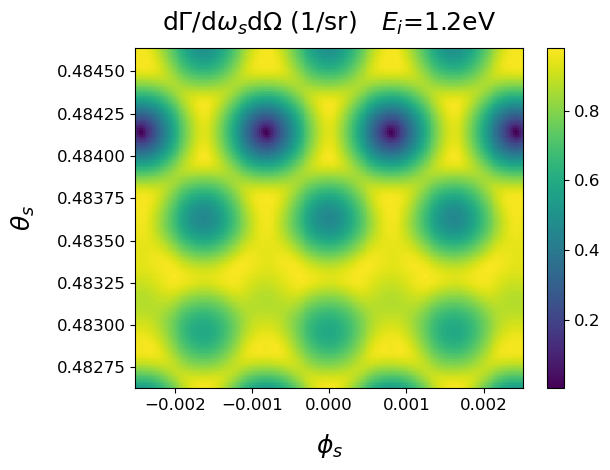

In [62]:
ωi = 1/ħeV #2/ħeV
Nangles = 200
dat = zeros(Nangles,Nangles)
θrange = range(θB - θdev, θB + θdev, length=Nangles)
ϕrange = range(-ϕdev, ϕdev, length=Nangles)
Δθ = θrange[2]-θrange[1]
Δϕ = ϕrange[2]-ϕrange[1]

# noffset, k0_vec_no_unit, k_r, M0, ωi, lor
# Threads.@threads for b in 1:Nb
#     newdat = [dΓdωdΩ_stitch_FCC(ωp - ωi, θs, ϕs, gvec, P, D_fcc_25, χ, np, L, b)*sin(θs)
#                         for θs in θrange, ϕs in ϕrange]
#     global dat .+= newdat
# end
dat = [info_stitch_FCC(ωp - ωi, θs, ϕs, gvec, P, D_dmnd_25, χ, np, L, 2)[5]*ħeV
                        for θs in θrange, ϕs in ϕrange]

dat_fcc_high = dat

pcolormesh(ϕrange, θrange, dat)
title(L"dΓ/d$ω_s$dΩ (1/sr) $~~E_i$=1.2eV", fontsize=18.0, pad=12)
xlabel(L"$ϕ_s$", fontsize=18.0, labelpad=14.0)
ylabel(L"$θ_s$", fontsize=18.0, labelpad=14)
colorbar()
tight_layout()

## Create BZ boundaries
### SC

In [74]:
ωs = ωp - 0.5/ħeV
θyl = [c/(ωs*sin(θB))*(π/a + 2π*n/a) for n in -4:3] #for y
θzl = [acos(-c/(ωs)*(π/a + 2*n*π/a) + ωp/ωs * cos(θB)) for n in -2:2]
θxl = [asin(-*(1+2*n)*π*c/(ωs*a) - ωp/ωs * sin(θB) + g*c/ωs) for n in -4:4]

ωs = ωp - 0.8/ħeV
θym = [c/(ωs*sin(θB))*(π/a + 2π*n/a) for n in -4:3] #for y
θzm = [acos(-c/(ωs)*(π/a + 2*n*π/a) + ωp/ωs * cos(θB)) for n in -2:2]
θxm = [asin(-*(1+2*n)*π*c/(ωs*a) - ωp/ωs * sin(θB) + g*c/ωs) for n in -4:4]

ωs = ωp - 1.7/ħeV
θyh = [c/(ωs*sin(θB))*(π/a + 2π*n/a) for n in -4:3] #for y
θzh = [acos(-c/(ωs)*(π/a + 2*n*π/a) + ωp/ωs * cos(θB)) for n in -2:2]
θxh = [asin(-*(1+2*n)*π*c/(ωs*a) - ωp/ωs * sin(θB) + g*c/ωs) for n in -4:4];

In [15]:
colors1l = zeros(Nangles, Nangles)
colors2l = zeros(Nangles, Nangles)
colors3l = zeros(Nangles, Nangles)
# θrange = range(θB - θdev, θB + θdev, length=Nangles)
# ϕrange = range(-ϕdev, ϕdev, length=Nangles)
Δθ = θrange[2]-θrange[1]
Δϕ = ϕrange[2]-ϕrange[1]
ωi = 0.4/ħeV
ωs = ωp - ωi

for (i, θs) in enumerate(θrange)
    for (j, ϕs) in enumerate(ϕrange)
        
        kBx = -ωs/c*sin(θs) - ωp/c*sin(θB) + gvec[3]
        kBy = -ωs/c*cos(θs)*sin(ϕs) + gvec[2]
        kBz = - ωs/c*cos(θs)*cos(ϕs) + ωp/c*cos(θB) + gvec[1]

        kBvec = [kBx, kBy, kBz]# .+ Goffset # in meters

        k0_vec_no_unit = (kBvec * a / (2π) .+ 100.5) .% 1 .- 0.5 # in MPB units

        offset = -floor.(kBvec*a/(2π) .+ 0.5)
        colors1l[i, j] = offset[1]
        colors2l[i, j] = offset[2]
        colors3l[i, j] = offset[3]
    end
end

# colors1m = zeros(Nangles, Nangles)
# colors2m = zeros(Nangles, Nangles)
# colors3m = zeros(Nangles, Nangles)
# ωi = 1/ħeV
# ωs = ωp - ωi

# for (i, θs) in enumerate(θrange)
#     for (j, ϕs) in enumerate(ϕrange)
#         kB0x = (-ωs/c*sin(θs)*cos(ϕs) - ωp/c*sin(θB) + gvec[1])*a/(2π)
#         kB0y = -ωs/c*sin(θs)*sin(ϕs)*a/(2π)
#         kB0z = (-ωs/c*cos(θs) + ωp/c*cos(θB))*a/(2π)
#         offset = bring_into_1BZ_FCC(kB0x, kB0y, kB0z)[2]
#         colors1m[i, j] = offset[1]
#         colors2m[i, j] = offset[2]
#         colors3m[i, j] = offset[3]
#     end
# end

# colors1h = zeros(Nangles, Nangles)
# colors2h = zeros(Nangles, Nangles)
# colors3h = zeros(Nangles, Nangles)
# ωi = 1.75/ħeV
# ωs = ωp - ωi

# for (i, θs) in enumerate(θrange)
#     for (j, ϕs) in enumerate(ϕrange)
#         kB0x = (-ωs/c*sin(θs)*cos(ϕs) - ωp/c*sin(θB) + gvec[1])*a/(2π)
#         kB0y = -ωs/c*sin(θs)*sin(ϕs)*a/(2π)
#         kB0z = (-ωs/c*cos(θs) + ωp/c*cos(θB))*a/(2π)
#         offset = bring_into_1BZ_FCC(kB0x, kB0y, kB0z)[2]
#         colors1h[i, j] = offset[1]
#         colors2h[i, j] = offset[2]
#         colors3h[i, j] = offset[3]
#     end
# end

### BCC/FCC

In [110]:
# create the BZ distinctions
Nangles = 100
colors1l = zeros(Nangles, Nangles)
colors2l = zeros(Nangles, Nangles)
colors3l = zeros(Nangles, Nangles)
θrange = range(θB - θdev, θB + θdev, length=Nangles)
ϕrange = range(-ϕdev, ϕdev, length=Nangles)
Δθ = θrange[2]-θrange[1]
Δϕ = ϕrange[2]-ϕrange[1]
ωi = 0.5/ħeV
ωs = ωp - ωi

for (i, θs) in enumerate(θrange)
    for (j, ϕs) in enumerate(ϕrange)
        kB0x = (-ωs/c*sin(θs)*cos(ϕs) - ωp/c*sin(θB) + gvec[1])*a/(2π)
        kB0y = -ωs/c*sin(θs)*sin(ϕs)*a/(2π)
        kB0z = (-ωs/c*cos(θs) + ωp/c*cos(θB))*a/(2π)
        offset = bring_into_1BZ_FCC(kB0x, kB0y, kB0z)[2]
        colors1l[i, j] = offset[1]
        colors2l[i, j] = offset[2]
        colors3l[i, j] = offset[3]
    end
end

colors1m = zeros(Nangles, Nangles)
colors2m = zeros(Nangles, Nangles)
colors3m = zeros(Nangles, Nangles)
ωi = 1/ħeV
ωs = ωp - ωi

for (i, θs) in enumerate(θrange)
    for (j, ϕs) in enumerate(ϕrange)
        kB0x = (-ωs/c*sin(θs)*cos(ϕs) - ωp/c*sin(θB) + gvec[1])*a/(2π)
        kB0y = -ωs/c*sin(θs)*sin(ϕs)*a/(2π)
        kB0z = (-ωs/c*cos(θs) + ωp/c*cos(θB))*a/(2π)
        offset = bring_into_1BZ_FCC(kB0x, kB0y, kB0z)[2]
        colors1m[i, j] = offset[1]
        colors2m[i, j] = offset[2]
        colors3m[i, j] = offset[3]
    end
end

colors1h = zeros(Nangles, Nangles)
colors2h = zeros(Nangles, Nangles)
colors3h = zeros(Nangles, Nangles)
ωi = 1.75/ħeV
ωs = ωp - ωi

for (i, θs) in enumerate(θrange)
    for (j, ϕs) in enumerate(ϕrange)
        kB0x = (-ωs/c*sin(θs)*cos(ϕs) - ωp/c*sin(θB) + gvec[1])*a/(2π)
        kB0y = -ωs/c*sin(θs)*sin(ϕs)*a/(2π)
        kB0z = (-ωs/c*cos(θs) + ωp/c*cos(θB))*a/(2π)
        offset = bring_into_1BZ_FCC(kB0x, kB0y, kB0z)[2]
        colors1h[i, j] = offset[1]
        colors2h[i, j] = offset[2]
        colors3h[i, j] = offset[3]
    end
end


In [88]:
for a in ax
    println(a.get_position())
end

PyObject Bbox([[0.125, 0.53], [0.35294117647058826, 0.88]])
PyObject Bbox([[0.125, 0.10999999999999999], [0.35294117647058826, 0.46]])
PyObject Bbox([[0.3985294117647059, 0.53], [0.6264705882352941, 0.88]])
PyObject Bbox([[0.3985294117647059, 0.10999999999999999], [0.6264705882352941, 0.46]])
PyObject Bbox([[0.6720588235294118, 0.53], [0.9000000000000001, 0.88]])
PyObject Bbox([[0.6720588235294118, 0.10999999999999999], [0.9000000000000001, 0.46]])


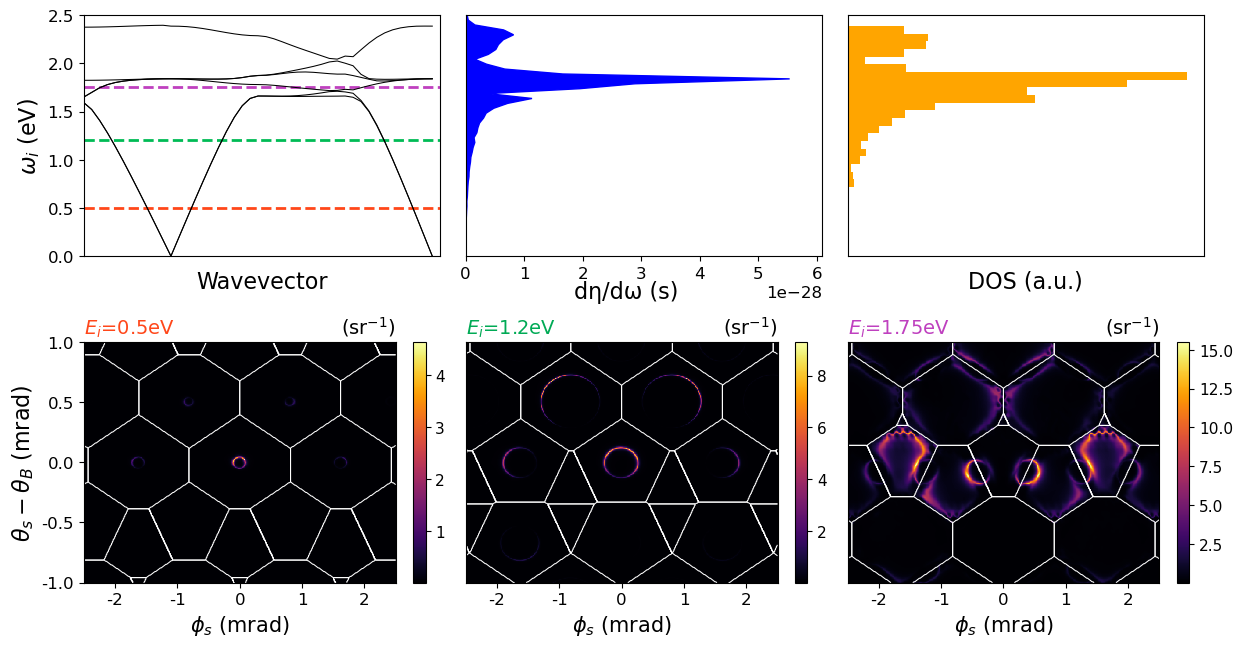

In [222]:
bands = npzread("phc3d_bands_fcc.npz")["arr_0"]

subplots(2,3,figsize=(12.5,6.5))
# subplots_adjust(hspace=0)
# ax = subplot(2,3,1)
# ax.axis("off")
# xticks([])
# yticks([])
# ax.text(0, 0.85, "BCC lattice", fontsize=16)

subplot(2,3,1)

PyPlot.plot(bands * 2π* c /0.5e-6 * ħeV, color="black")
hlines([0.5,1.2,1.75], 0, length(bands), colors=["#ff471a","#00BB55","#bf40bf"], linewidths=2, linestyles="dashed")
xlim(0,45)
xlabel("Wavevector", fontsize=16, labelpad=10)
ylabel(L"$ω_i$ (eV)", fontsize=16)
ylim(0, 2.5)
xticks([])

subplot(2,3,2)

Ep2 = ħ*np*ωp/(2*ϵ0) 

ωirange = range(0.01/ħeV, 2.5/ħeV, length=50)

fill(dηdω_fcc, ωirange*ħeV, color="blue")
#title("Efficiency spectrum")
ylim(0, 2.5)
xlim(0, 1.1*maximum(dηdω_fcc))
xlabel("dη/dω (s)     ", fontsize=16, labelpad=-0.5)
yticks([])

data = npzread("phc3d_fcc.npz")
ωdat = data["arr_4"]

subplot(2,3,3)
hist(vec(ωdat * 2π*c/a* ħeV), bins=30,orientation="horizontal", color="orange") 
ylim(0, 2.5)
xlabel("DOS (a.u.)", fontsize=16, labelpad=10)
yticks([])
xticks([])


Nangles = 400
θrange = range(θB - θdev, θB + θdev, length=Nangles)
ϕrange = range(-ϕdev, ϕdev, length=Nangles)

subplot(2,3,4)
pcolormesh(ϕrange, θrange, dat_fcc_low, cmap="inferno")
title(L"(sr$^{-1}$)", fontsize=14.0, loc="right")
title(L"$E_i$=0.5eV", fontsize=14.0, loc="left", color="#ff471a")

xlabel(L"$ϕ_s$ (mrad)", fontsize=15.0)
ylabel(L"$θ_s-θ_B$ (mrad)", fontsize=16.0)
xticks(collect(-0.002:0.001:0.002), collect(-2:1:2))
yticks(collect(-1:0.5:1)./1000 .+ θB, collect(-1:0.5:1))
xlim(minimum(ϕrange), maximum(ϕrange))
ylim(minimum(θrange), maximum(θrange))
cb = colorbar(fraction=0.075)
cb.ax.tick_params(labelsize=11) 

# hlines(θxl, minimum(ϕrange), maximum(ϕrange), "white")
# hlines(θzl, minimum(ϕrange), maximum(ϕrange), "white")
# vlines(θyl, minimum(θrange), maximum(θrange), "white")

PyPlot.contour(ϕrange, θrange, colors1l, levels=-5.5:5.5, colors=["white"])
PyPlot.contour(ϕrange, θrange, colors2l, levels=-5.5:5.5, colors=["white"])
PyPlot.contour(ϕrange, θrange, colors3l, levels=-5.5:5.5, colors=["white"])

subplot(2,3,5)
pcolormesh(ϕrange, θrange, dat_fcc_med, cmap="inferno")
title(L"$E_i$=1.2eV", fontsize=14.0, loc="left", color="#00AA55")
title(L"(sr$^{-1}$)", fontsize=14.0, loc="right")

xlabel(L"$ϕ_s$ (mrad)", fontsize=15.0)
xticks(collect(-0.002:0.001:0.002), collect(-2:1:2))
yticks([])
xlim(minimum(ϕrange), maximum(ϕrange))
ylim(minimum(θrange), maximum(θrange))

cb = colorbar(fraction=0.075)
cb.ax.tick_params(labelsize=11) 

PyPlot.contour(ϕrange, θrange, colors1m, levels=-5.5:5.5, colors=["white"])
PyPlot.contour(ϕrange, θrange, colors2m, levels=-5.5:5.5, colors=["white"])
PyPlot.contour(ϕrange, θrange, colors3m, levels=-5.5:5.5, colors=["white"])


# hlines(θxm, minimum(ϕrange), maximum(ϕrange), "white")
# hlines(θzm, minimum(ϕrange), maximum(ϕrange), "white")
# vlines(θym, minimum(θrange), maximum(θrange), "white")

subplot(2,3,6)
pcolormesh(ϕrange, θrange, dat_fcc_high, cmap="inferno")
title(L"$E_i$=1.75eV", fontsize=14.0, loc="left", color="#bf40bf")
title(L"(sr$^{-1}$)", fontsize=14.0, loc="right")

xlabel(L"$ϕ_s$ (mrad)", fontsize=15.0)
xticks(collect(-0.002:0.001:0.002), collect(-2:1:2))
yticks([])
xlim(minimum(ϕrange), maximum(ϕrange))
ylim(minimum(θrange), maximum(θrange))

cb = colorbar(fraction=0.075)
cb.ax.tick_params(labelsize=11) 

PyPlot.contour(ϕrange, θrange, colors1h, levels=-5.5:5.5, colors=["white"])
PyPlot.contour(ϕrange, θrange, colors2h, levels=-5.5:5.5, colors=["white"])
PyPlot.contour(ϕrange, θrange, colors3h, levels=-5.5:5.5, colors=["white"])

# hlines(θxh, minimum(ϕrange), maximum(ϕrange), "white")
# hlines(θzh, minimum(ϕrange), maximum(ϕrange), "white")
# vlines(θyh, minimum(θrange), maximum(θrange), "white")

tight_layout(pad=0.8)
# PyPlot.savefig("sc_6fig_sphere_0-2_noschem.png", dpi=300)

## 3 panel figure

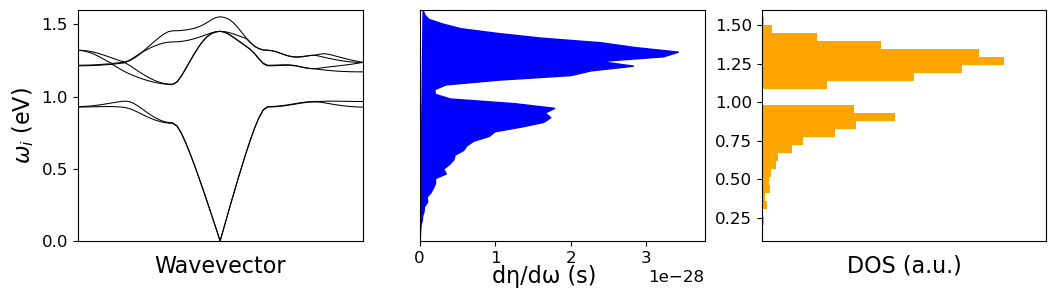

(Any[], Any[])

In [59]:
bands = npzread("phc3d_dmnd_bands.npz")["arr_0"]

subplots(1,3,figsize=(12.5,3))
subplot(1,3,1)
Emax = 1.6

PyPlot.plot(bands * 2π* c /0.5e-6 * ħeV, color="black")
# hlines([0.5,1.2,1.75], 0, length(bands), colors=["#ff471a","#00BB55","#bf40bf"], linewidths=2, linestyles="dashed")
xlim(0,size(bands)[1]-1)
xlabel("Wavevector", fontsize=16, labelpad=10)
ylabel(L"$ω_i$ (eV)", fontsize=16)
ylim(0, Emax)
xticks([])

subplot(1,3,2)

Ep2 = ħ*np*ωp/(2*ϵ0) 

ωirange = range(0.01/ħeV, Emax/ħeV, length=50)

fill(dηdω_dmnd_25, ωirange*ħeV, color="blue")
#title("Efficiency spectrum")
ylim(0, Emax)
xlim(0, 1.1*maximum(dηdω_dmnd_25))
xlabel("dη/dω (s)     ", fontsize=16, labelpad=-0.5)
yticks([])

data = npzread("phc3d_dmnd_25.npz")
ωdat = data["arr_4"]

subplot(1,3,3)
hist(vec(ωdat * 2π*c/a* ħeV), bins=30,orientation="horizontal", color="orange") 
ylim(0.1, Emax)
xlim(0,8000)
xlabel("DOS (a.u.)", fontsize=16, labelpad=10)
# yticks([])
xticks([])

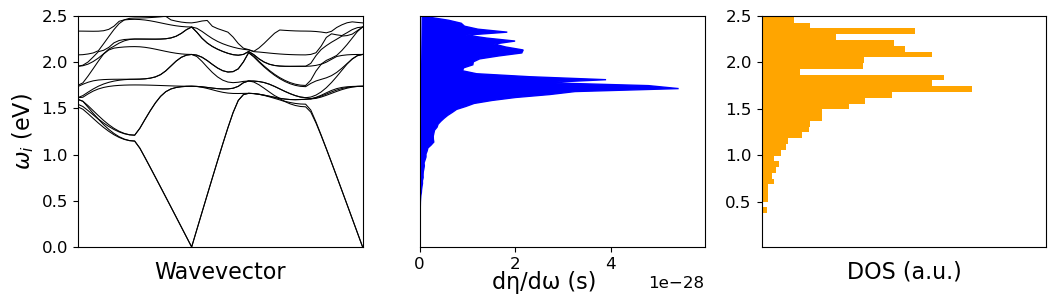

(Any[], Any[])

In [56]:
bands = npzread("phc3d_sc_bands_12.npz")["arr_0"]

subplots(1,3,figsize=(12.5,3))
subplot(1,3,1)
Emax = 2.5

PyPlot.plot(bands * 2π* c /0.5e-6 * ħeV, color="black")
# hlines([0.5,1.2,1.75], 0, length(bands), colors=["#ff471a","#00BB55","#bf40bf"], linewidths=2, linestyles="dashed")
xlim(0,size(bands)[1]-1)
xlabel("Wavevector", fontsize=16, labelpad=10)
ylabel(L"$ω_i$ (eV)", fontsize=16)
ylim(0, Emax)
xticks([])

subplot(1,3,2)

Ep2 = ħ*np*ωp/(2*ϵ0) 

# ωirange = range(0.01/ħeV, Emax/ħeV, length=Nω)

fill(dηdω_sc, ωirange*ħeV, color="blue")
#title("Efficiency spectrum")
ylim(0, Emax)
xlim(0, 1.1*maximum(dηdω_sc))
xlabel("dη/dω (s)     ", fontsize=16, labelpad=-0.5)
yticks([])

data = npzread("phc3d_sc_15_12b.npz")
ωdat = data["arr_4"]

subplot(1,3,3)
hist(vec(ωdat * 2π*c/a* ħeV), bins=40,orientation="horizontal", color="orange") 
ylim(0.01, Emax)
xlim(0,5000)
xlabel("DOS (a.u.)", fontsize=16, labelpad=10)
# yticks([])
xticks([])

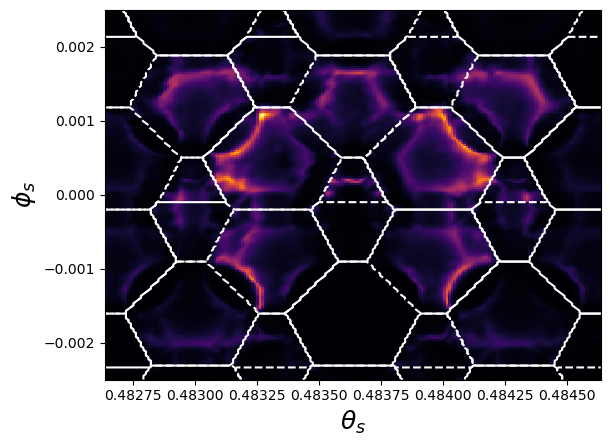

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


PyObject Text(38.0, 0.5, '$\\phi_s$')

In [206]:
pcolormesh(θrange, ϕrange, dat, cmap="inferno")
contour(θrange, ϕrange, colors1, levels=-5.5:5.5, colors=["white"], linestyle="solid")
contour(θrange, ϕrange, colors2, levels=-5.5:5.5, colors=["white"], linestyle="solid")
contour(θrange, ϕrange, colors3, levels=-5.5:5.5, colors=["white"], linestyle="solid")
xlabel(L"$\theta_s$", fontsize=18)
ylabel(L"$\phi_s$", fontsize=18)

## Frequency spectrum
### Free space

In [119]:
θdev = 0.001
ϕdev = 0.0025

Nω = 50
Nangles = 175

θrange = range(θB - θdev/2, θB + θdev/2, length=Nangles)
ϕrange = range(-ϕdev/2, ϕdev/2, length=Nangles)
Δθ = θrange[2]-θrange[1]
Δϕ = ϕrange[2]-ϕrange[1]

ωirange_fs = range(0.01/ħeV, 2.5/ħeV, length=Nω)
dηdω_fs_esc = zeros(Nω)
dat = zeros(Nangles, Nangles)


for (i, ωi) in enumerate(ωirange_fs)
    println("omega i = ", string(i))
    dat = [dΓdωdΩ_free(ωp - ωi, θs, ϕs, gvec, P, 1.369, χ, np, L)*sin(θs)
                        for θs in θrange, ϕs in ϕrange]
    dηdω_fs_esc[i] = sum(dat)*Δθ*Δϕ/(np*c*L^2)
end

omega i = 1
omega i = 2
omega i = 3
omega i = 4
omega i = 5
omega i = 6
omega i = 7
omega i = 8
omega i = 9
omega i = 10
omega i = 11
omega i = 12
omega i = 13
omega i = 14
omega i = 15
omega i = 16
omega i = 17
omega i = 18
omega i = 19
omega i = 20
omega i = 21
omega i = 22
omega i = 23
omega i = 24
omega i = 25
omega i = 26
omega i = 27
omega i = 28
omega i = 29
omega i = 30
omega i = 31
omega i = 32
omega i = 33
omega i = 34
omega i = 35
omega i = 36
omega i = 37
omega i = 38
omega i = 39
omega i = 40
omega i = 41
omega i = 42
omega i = 43
omega i = 44
omega i = 45
omega i = 46
omega i = 47
omega i = 48
omega i = 49
omega i = 50


### Simple cubic

In [55]:
θdev = 0.001
ϕdev = 0.0025

Nω = 80
Nangles = 100

θrange = range(θB - θdev, θB + θdev, length=Nangles)
ϕrange = range(-ϕdev, ϕdev, length=Nangles)
Δθ = θrange[2]-θrange[1]
Δϕ = ϕrange[2]-ϕrange[1]

ωirange = range(0.01/ħeV, 2.55/ħeV, length=Nω)
dηdω_sc = zeros(Nω)

for (i, ωi) in enumerate(ωirange)
    println("omega i = ", string(i))
    dat = zeros(Nangles, Nangles)
    Threads.@threads for b in 1:12 # CHANGED DUE TO MORE BANDS
        newdat = [dΓdωdΩ_stitch(ωp - ωi, θs, ϕs, gvec, P, D_sc_15_12b, χ, np, L, b)*sin(θs)
                            for θs in θrange, ϕs in ϕrange]
        global dat = dat .+ newdat
    end
    dηdω_sc[i] = sum(dat)*Δθ*Δϕ/(np*c*L^2)
end

omega i = 1
omega i = 2
omega i = 3
omega i = 4
omega i = 5
omega i = 6
omega i = 7
omega i = 8
omega i = 9
omega i = 10
omega i = 11
omega i = 12
omega i = 13
omega i = 14
omega i = 15
omega i = 16
omega i = 17
omega i = 18
omega i = 19
omega i = 20
omega i = 21
omega i = 22
omega i = 23
omega i = 24
omega i = 25
omega i = 26
omega i = 27
omega i = 28
omega i = 29
omega i = 30
omega i = 31
omega i = 32
omega i = 33
omega i = 34
omega i = 35
omega i = 36
omega i = 37
omega i = 38
omega i = 39
omega i = 40
omega i = 41
omega i = 42
omega i = 43
omega i = 44
omega i = 45
omega i = 46
omega i = 47
omega i = 48
omega i = 49
omega i = 50
omega i = 51
omega i = 52
omega i = 53
omega i = 54
omega i = 55
omega i = 56
omega i = 57
omega i = 58
omega i = 59
omega i = 60
omega i = 61
omega i = 62
omega i = 63
omega i = 64
omega i = 65
omega i = 66
omega i = 67
omega i = 68
omega i = 69
omega i = 70
omega i = 71
omega i = 72
omega i = 73
omega i = 74
omega i = 75
omega i = 76
omega i = 77
omega i 

### BCC

In [ ]:
θdev = 0.001
ϕdev = 0.0025

Nω = 50
Nangles = 100

θrange = range(θB - θdev, θB + θdev, length=Nangles)
ϕrange = range(-ϕdev, ϕdev, length=Nangles)
Δθ = θrange[2]-θrange[1]
Δϕ = ϕrange[2]-ϕrange[1]

# ωirange_fs = range(0.01/ħeV, 1/ħeV, length=Nω)
dηdω_bcc = zeros(Nω)

for (i, ωi) in enumerate(ωirange)
    println("omega i = ", string(i))
    dat = zeros(Nangles, Nangles)
    Threads.@threads for b in 1:Nb
        newdat = [dΓdωdΩ_stitch_BCC(ωp - ωi, θs, ϕs, gvec, P, D_bcc_21, χ, np, L, b)*sin(θs)
                            for θs in θrange, ϕs in ϕrange]
        global dat = dat .+ newdat
    end
    dηdω_bcc[i] = sum(dat)*Δθ*Δϕ/(np*c*L^2)
end

### FCC

In [ ]:
θdev = 0.001
ϕdev = 0.0025

Nω = 50
Nangles = 80

θrange = range(θB - θdev, θB + θdev, length=Nangles)
ϕrange = range(-ϕdev, ϕdev, length=Nangles)
Δθ = θrange[2]-θrange[1]
Δϕ = ϕrange[2]-ϕrange[1]

# ωirange_fs = range(0.01/ħeV, 1/ħeV, length=Nω)
dηdω_fcc = zeros(Nω)

for (i, ωi) in enumerate(ωirange)
    println("omega i = ", string(i))
    dat = zeros(Nangles, Nangles)
    Threads.@threads for b in 1:Nb
        newdat = [dΓdωdΩ_stitch_FCC(ωp - ωi, θs, ϕs, gvec, P, D_fcc_21, χ, np, L, b)*sin(θs)
                            for θs in θrange, ϕs in ϕrange]
        global dat = dat .+ newdat
    end
    dηdω_fcc[i] = sum(dat)*Δθ*Δϕ/(np*c*L^2)
end

### Diamond

In [60]:
θdev = 0.001
ϕdev = 0.0025

Nω = 50
Nangles = 150

θrange = range(θB - θdev, θB + θdev, length=Nangles)
ϕrange = range(-ϕdev, ϕdev, length=Nangles)
Δθ = θrange[2]-θrange[1]
Δϕ = ϕrange[2]-ϕrange[1]

ωirange = range(0.01/ħeV, 1.6/ħeV, length=Nω)
# dηdω_dmnd_25 = zeros(Nω)
dηdω_dmnd_25_nar_f = zeros(Nω)

for (i, ωi) in enumerate(ωirange)
    println("omega i = ", string(i))
#     global dat = zeros(Nangles, Nangles)
#     Threads.@threads for b in 1:Nb
#         newdat = [dΓdωdΩ_stitch_FCC(ωp - ωi, θs, ϕs, gvec, P, D_dmnd_25, χ, np, L, b)*sin(θs)
#                             for θs in θrange, ϕs in ϕrange]
#         global dat = dat .+ newdat
#     end
#     dηdω_dmnd_25[i] = sum(dat)*Δθ*Δϕ/(np*c*L^2)
    
    global dat = zeros(Nangles, Nangles)
    Threads.@threads for b in 1:Nb
        newdat = [dΓdωdΩ_stitch_FCC(ωp - ωi, θs, ϕs, gvec, P, D_dmnd_25, χ, np, L, b, 1, 0.1e14)*sin(θs)
                            for θs in θrange, ϕs in ϕrange]
        global dat = dat .+ newdat
    end
    dηdω_dmnd_25_nar_f[i] = sum(dat)*Δθ*Δϕ/(np*c*L^2)
end

omega i = 1
omega i = 2
omega i = 3
omega i = 4
omega i = 5
omega i = 6
omega i = 7
omega i = 8
omega i = 9
omega i = 10
omega i = 11
omega i = 12
omega i = 13
omega i = 14
omega i = 15
omega i = 16
omega i = 17
omega i = 18
omega i = 19
omega i = 20
omega i = 21
omega i = 22
omega i = 23
omega i = 24
omega i = 25
omega i = 26
omega i = 27
omega i = 28
omega i = 29
omega i = 30
omega i = 31
omega i = 32
omega i = 33
omega i = 34
omega i = 35
omega i = 36
omega i = 37
omega i = 38
omega i = 39
omega i = 40
omega i = 41
omega i = 42
omega i = 43
omega i = 44
omega i = 45
omega i = 46
omega i = 47
omega i = 48
omega i = 49
omega i = 50


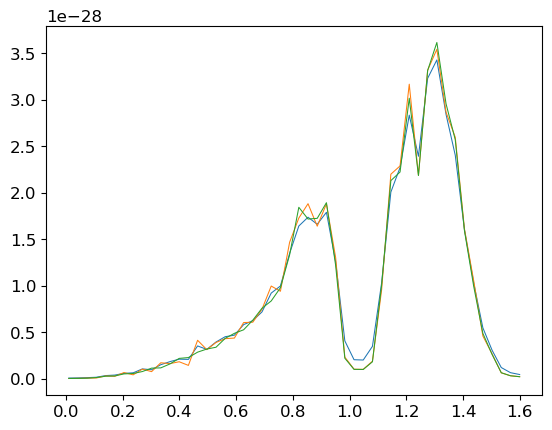

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f41ee564310>

In [61]:
PyPlot.plot(ωirange*ħeV, dηdω_dmnd_25)
# ylim(0,4e-28)
PyPlot.plot(ωirange*ħeV, dηdω_dmnd_25_nar)
PyPlot.plot(ωirange*ħeV, dηdω_dmnd_25_nar_f)

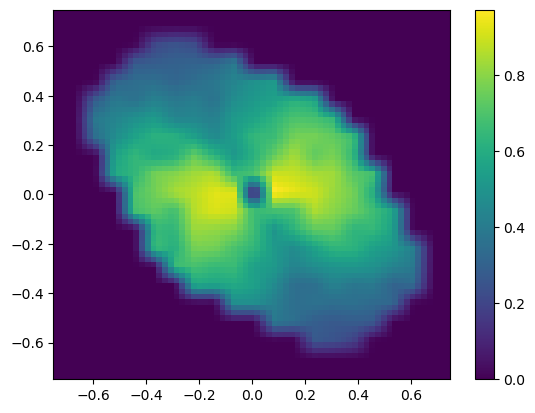

PyObject <matplotlib.colorbar.Colorbar object at 0x7fec1153cc50>

In [117]:
band = 1
nx = 4
ny = 4
nz = 4
kx = 0
ky = 0
kz = 0
ωitp = interpolate(ωdat[band,:,:,:], BSpline(Linear()));
ωsitp = scale(ωitp, krange, krange, krange);

Mitp = interpolate(M1dat[band,:,:,:,nx,ny,nz] .* ks_1BZ_BCC, BSpline(Linear()));
Msitp = scale(Mitp, krange, krange, krange);

ks = range(-0.749,0.749,length=70)
plotdat = [Msitp(kx, ky, kz) for kx in ks, ky in ks]

# plotdat = [D.Mspline[band, 4, 4, 4, 1](kx, ky, 0) for kx in ks, ky in ks]

Mitp = interpolate(M1dat[band + 1,:,:,:,nx,ny,nz] .* ks_1BZ_BCC, BSpline(Linear()));
Msitp = scale(Mitp, krange, krange, krange);

plotdat .+= [Msitp(kx, ky, kz) for kx in ks, ky in ks]

# plotdat .+= [D.Mspline[band + 1, 4, 4, 4, 1](kx, ky, 0) for kx in ks, ky in ks]
pcolormesh(ks, ks, plotdat)
colorbar()

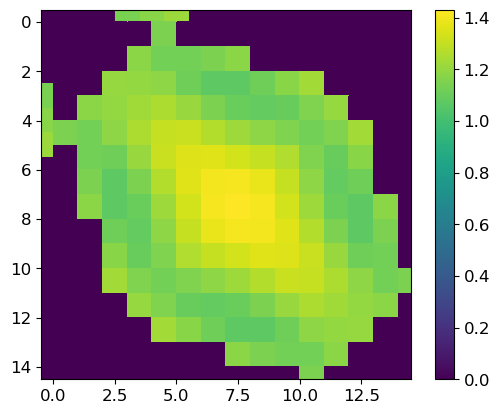

PyObject <matplotlib.colorbar.Colorbar object at 0x7f328322d750>

In [94]:
band = 3
nx = 4
ny = 4
nz = 4
kx = 0
ky = 0
kz = 0
ωitp = interpolate(ωdat[band,:,:,:], BSpline(Quadratic(Flat(OnCell()))));
ωsitp = scale(ωitp, krange, krange, krange);

Mitp = interpolate(M1dat[band,:,:,:,nx,ny,nz], BSpline(Linear()));
Msitp = scale(Mitp, krange, krange, krange);

ks = range(-0.49,0.49,length=70)
plotdat = [ωsitp(kx, ky, kz)* 2*π*c/a*ħeV for kx in krange, ky in krange]
pcolormesh(plotdat)
show()
plotdat = ωdat[band,7,:,:].*(2*π*c/a*ħeV)
imshow(plotdat)
show()

# plotdat = [D.Mspline[band, 4, 4, 4, 1](kx, ky, 0) for kx in ks, ky in ks]


colorbar()

In [14]:
ωs = zeros(70, 70)
for i in 1:69
    for j in 1:69
        k = bring_into_1BZ_BCC(ks[i], ks[j], 0.15)[1]
        ωs[i,j] = Msplines[2,4,4,4,1](k[1], k[2], k[3])^2 + Msplines[1,4,4,4,1](k[1], k[2], k[3])^2
    end
end
imshow(ωs)
colorbar()

LoadError: UndefVarError: Msplines not defined

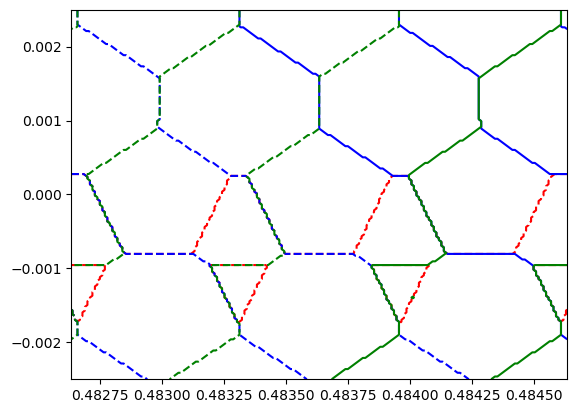

None of these options worked :'(
None of these options worked :'(


PyObject <matplotlib.contour.QuadContourSet object at 0x7f7042f5f2d0>

In [59]:
colors1 = zeros(Nangles, Nangles)
colors2 = zeros(Nangles, Nangles)
colors3 = zeros(Nangles, Nangles)

for (i, θs) in enumerate(θrange)
    for (j, ϕs) in enumerate(ϕrange)
        kB0x = (-ωs/c*sin(θs)*cos(ϕs) - ωp/c*sin(θB) + gvec[1])* D.a/(2π)
        kB0y = -ωs/c*sin(θs)*sin(ϕs)*D.a/(2π)
        kB0z = (-ωs/c*cos(θs) + ωp/c*cos(θB))*D.a/(2π)
        offset = bring_into_1BZ_FCC(kB0x, kB0y, kB0z)[2]
        colors1[i, j] = offset[1]
        colors2[i, j] = offset[2]
        colors3[i, j] = offset[3]

    end
end
contour(θrange, ϕrange, colors1, levels=-5.5:5.5, colors=["red"])
contour(θrange, ϕrange, colors2, levels=-5.5:5.5, colors=["blue"])
contour(θrange, ϕrange, colors3, levels=-5.5:5.5, colors=["green"])


In [233]:
BCC_to_cartesian_recip * cartesian_to_BCC_recip

3×3 Array{Float64,2}:
 1.0  0.0  0.0
 0.0  1.0  0.0
 0.0  0.0  1.0

In [93]:
function zone_map(ωs, θs, ϕs, gvec, P::PumpBeam, D::PhC_Data, noffset)
    ωp = P.ωp
    θp = P.θp 
    ϕp = P.ϕp
    
    kp = ωp/c
    ks = ωs/c
    
    a = D.a
    
#     nx, ny, nz = noffset .+ [4, 4, 4]
#     Mspline = D.Mspline[band, nx, ny, nz]
#     ωspline = D.ωspline[band]
    
#     kpvec = kp*[sin(θp)*cos(ϕp), sin(θp)*sin(ϕp), cos(θp)]
#     ksvec = ks*[sin(θs)*cos(ϕs), sin(θs)*sin(ϕs), cos(θs)]
    

#     k0vec = gvec .+ kpvec .- ksvec
    g = gvec[1] #assuming in the x direction
    Goffset = 2π/a * noffset #reciprocal lattice vector offset

    kBx = -ks*sin(θs)*cos(ϕs) - kp*sin(θp) + g
    kBy = -ks*sin(θs)*sin(ϕs)
    kBz = -ks*cos(θs) + kp*cos(θp)

    kBvec = [kBx, kBy, kBz] .+ Goffset

    k0_vec_no_unit = kBvec * a / (2π)
    return k0_vec_no_unit
end

zone_map (generic function with 1 method)

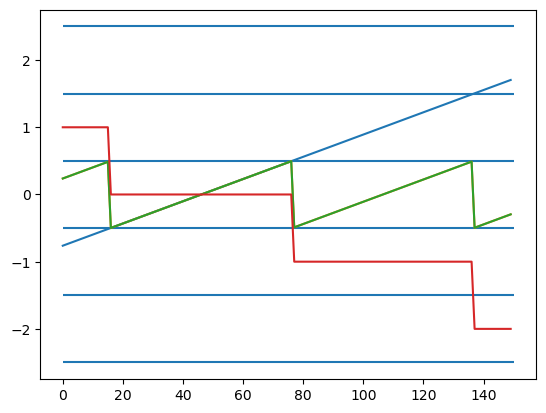

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f6236c21210>

In [164]:
# Test of bringing k into 1BZ
kp = ωp/c
ks = ωs/c
ϕs = 0
kBs = zeros(Nangles)
ns = zeros(Nangles)
θx = [asin(-(1+2*n)*π*c/(ωs*a) - ωp/ωs * sin(θB) + g*c/ωs) for n in -5:5]
θy = [c/(ωs*sin(θB))*(π/a + 2π*n/a) for n in -5:5] #for y
θz = [acos(-c/(ωs)*(π/a + 2*n*π/a) + ωp/ωs * cos(θB)) for n in -5:5]
θs = θB
for (i, θs) in enumerate(θrange)
    kBx = -ks*sin(θs)*cos(ϕs) - kp*sin(θB) + g
    kBy = -ks*sin(θs)*sin(ϕs)
    kBz = -ks*cos(θs) + kp*cos(θB)
    kBs[i] = kBz
    
    ny = (bin(ϕs, θy) - 5)
    nx = bin(θs, reverse(θx)) - 6
    nz = -(bin(θs, θz) - 5)
    ns[i] = nz
end

plot(kBs*a/(2π))
plot(kBs*a/(2π) .+ ns)
plot((kBs*a/(2π) .+ 5.5) .% 1 .- 0.5)
hlines(-2.5:2.5, 0, Nangles)
plot(ns)

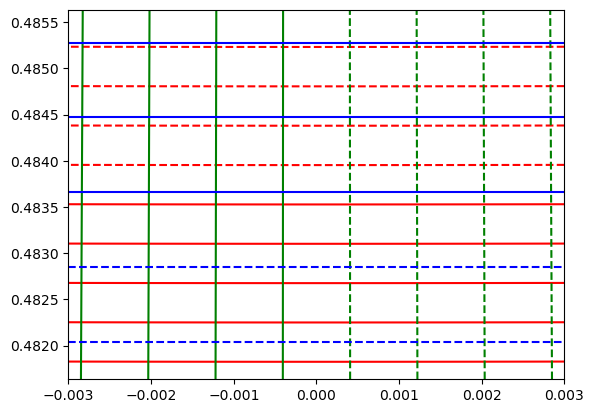

In [94]:
θrange = range(θB - 0.002, θB + 0.002, length=200)
ϕrange = range(-0.003, 0.003, length=200)

clist = ["red", "green", "blue"]

for dir in 1:3
    dat = [zone_map(ωp - ωi, θs, ϕs, gvec, P, D, [0,0,0])[dir]
                            for θs in θrange, ϕs in ϕrange]
    #pcolormesh(dat)
    contour(ϕrange, θrange, dat, levels=-5.5:5.5, colors=[clist[dir]])
end

# hlines(θx, minimum(ϕrange), maximum(ϕrange))
# vlines(θy, minimum(θrange), maximum(θrange))

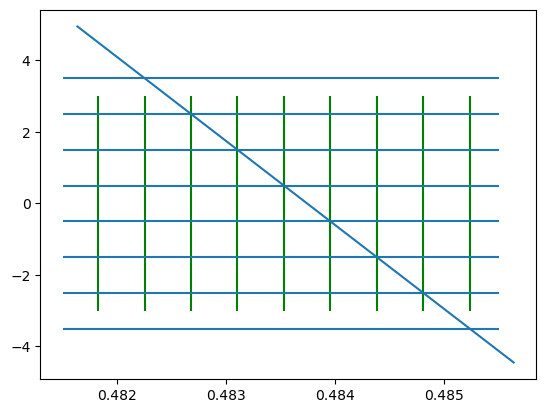

PyObject <matplotlib.collections.LineCollection object at 0x7f704ad98ad0>

In [196]:
plot(θrange, [zone_map(ωp - ωi, θs, 0, gvec, P, D, [0,0,0])[1] for θs in θrange])
vlines(θx, -3,3, "green")
hlines(-3.5:3.5, 0.4815,0.4855)

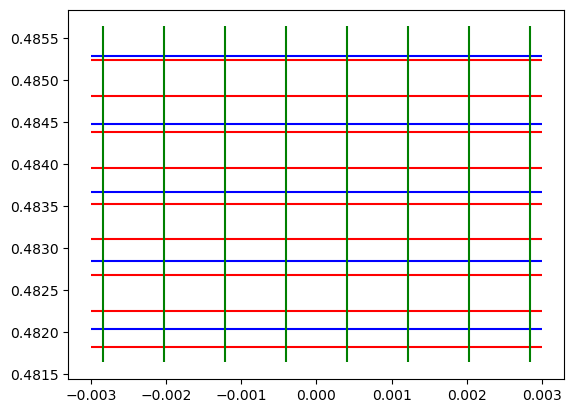

PyObject <matplotlib.collections.LineCollection object at 0x7f704b25ccd0>

In [184]:

a = 0.5e-6
θy = [c/(ωs*sin(θB))*(π/a + 2π*n/a) for n in -4:3] #for y
θz = [acos(-c/(ωs)*(π/a + 2*n*π/a) + ωp/ωs * cos(θB)) for n in -2:2]
θx = [asin(-*(1+2*n)*π*c/(ωs*a) - ωp/ωs * sin(θB) + g*c/ωs) for n in -4:4]

hlines(θx, minimum(ϕrange), maximum(ϕrange), "red")
hlines(θz, minimum(ϕrange), maximum(ϕrange), "blue")
vlines(θy, minimum(θrange), maximum(θrange), "green")


    

#next step is to take an angle and put it in a zone. 